<a href="https://colab.research.google.com/github/StylianosHerodotou/CreditScoringPredictor/blob/main/EPL448_presentationNotebook_905811_904311.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Welcome to our presentation of Credit Scoring as part of our Data Science Class- EPL448*

We would like thank Dr Agathocleus and Mr. Kipros from Goldman Solutions & Services for the dataset and the guidance to constructng this notebook. 

##First lets import some libraries and create some functions that will be useful later in the notebook 

###Imports

In [1]:
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from scipy.stats import uniform
from sklearn import svm
from sklearn.datasets import load_iris
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import chi2
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from statistics import mean 
from statistics import stdev
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import io
import math
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import pandas.plotting as pdplt
import requests
import seaborn as sns
import tensorflow as tf
import time

###The below are the implementations of some functions we will use below. We should ignore the implementation for now, but we will see them again below in their respective sections.

In [2]:
def find_columns(df, column_indexes):
    all_columns=df.columns
    new_columns=[]
    for index in column_indexes:
        new_columns.append(all_columns[index])
    return new_columns

#checked
def remove_features_with_low_variance(df):
    variances=df.var(axis=0)
    n=math.ceil((len(variances)/3))
    nsmallest=variances.nsmallest(n=n)
    threshold=nsmallest.mean()
    sel = VarianceThreshold(threshold=threshold)
    sel.fit_transform(df)
    column_indexes=sel.get_support(["index"])
    new_columns=find_columns(df,column_indexes)
    if("Score" not in new_columns):
        new_columns.append("Score")
    new_df=df[new_columns]
    return new_df

#checked
def SelectKBest_attributes(df,k=10,score_function=chi2):
    if(k>=len(df.columns)):
        return df
    X = df.iloc[:,0:-1]  #independent columns
    y = df.iloc[:,-1]    #target column i.e price range
    if("Id" in X.columns):
        X=X.drop("Id",axis=1)
    #apply SelectKBest class to extract top 10 best features
    bestfeatures = SelectKBest(score_func=score_function, k=k)
    bestfeatures.fit_transform(X,y)
    column_indexes=bestfeatures.get_support(["index"])
    new_columns=find_columns(df,column_indexes)
    if("Id" not in new_columns):
        new_columns.append("Id")
    if("Score" not in new_columns):
        new_columns.append("Score")
    new_df=df[new_columns]
    return new_df

    #checked
def l1_l2_based_feaure_selection(df, c=0.01,penalty="l1",sparse_estimator="lsvc"):
    X = df.iloc[:,0:-1]  #independent columns
    y = df.iloc[:,-1]    #target column i.e price range
    if(sparse_estimator=="lsvc"):
        lsvc = LinearSVC(C=0.01, penalty=penalty, dual=False).fit(X, y)
        model = SelectFromModel(lsvc, prefit=True)
        X_new = model.transform(X)
        
    else:
        lreg = LogisticRegression(C=0.01, penalty="l2", dual=False).fit(X, y)
        model = SelectFromModel(lreg, prefit=True)
        X_new = model.transform(X)
    column_indexes=model.get_support(["index"])
    new_columns=find_columns(df,column_indexes)
    if("Score" not in new_columns):
        new_columns.append("Score")
    new_df=df[new_columns]
    return new_df

def Tree_based_feature_selection(df,n_estimators=50):
    X = df.iloc[:,0:-1]  #independent columns
    y = df.iloc[:,-1]    #target column i.e price range
    clf = ExtraTreesClassifier(n_estimators=n_estimators)
    clf = clf.fit(X, y)
    model = SelectFromModel(clf, prefit=True)
    model.transform(X)
    column_indexes=model.get_support(["index"])
    new_columns=find_columns(df,column_indexes)
    if("Score" not in new_columns):
        new_columns.append("Score")
    new_df=df[new_columns]
    return new_df

#checked
def Recursive_feature_elimination_with_cross_validation(df,c=1.0):
    # Build a classification task using 3 informative features
    X = df.iloc[:,0:-1]  #independent columns
    y = df.iloc[:,-1]    #target column i.e price range
    # Create the RFE object and compute a cross-validated score.
    svc = SVC(C=c,kernel="linear")
    # The "accuracy" scoring is proportional to the number of correct
    # classifications
    rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
                  scoring='accuracy')
    rfecv.fit_transform(X, y)
    column_indexes=rfecv.get_support(["index"])
    new_columns=find_columns(df,column_indexes)
    if("Score" not in new_columns):
        new_columns.append("Score")
    new_df=df[new_columns]
    return new_df

#checked
def Recursive_feature_elimination(df,c=1.0):
    X = df.iloc[:,0:-1]  #independent columns
    y = df.iloc[:,-1]    #target column i.e price range

    # Create the RFE object and rank each pixel
    svc = SVC(C=c,kernel="linear")
    rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
    rfe.fit_transform(X, y)
    column_indexes=rfe.get_support(["index"])
    new_columns=find_columns(df,column_indexes)
    if("Score" not in new_columns):
        new_columns.append("Score")
    new_df=df[new_columns]
    return new_df


#NEEDS checking
# Forward selection
#start with a model with no features
# add a feature that maximizes criterion function
# repeat for all other features. 
# choose and add only the feature that had the best performance. 
# Now the model has one model, repat for from the third line. After doing it for all features then you add the second one. 
# finish when you reach desired number of features. 
from sklearn.naive_bayes import GaussianNB
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

def forwardSelection(df,NumberofFeatures=5, forward=True):
  X = df.iloc[:,0:-1]  #independent columns
  y = df.iloc[:,-1]    #target column i.e price range
  classifier =  GaussianNB()
  # Sequential Forward Selection
  sfs = SFS(classifier, 
            k_features=NumberofFeatures, 
            forward=forward, 
            floating=False, 
            verbose=2,
            scoring='accuracy',
            cv=10)

  sfs = sfs.fit(X, y)
  column_indexes=sfs.k_feature_idx_
  new_columns=find_columns(df,column_indexes)
  if("Score" not in new_columns):
      new_columns.append("Score")
  new_df=df[new_columns]
  return new_df

  
  # print('\nSequential Forward Selection (k=5):')
  # print('Selected features:',sfs.k_feature_idx_)
  # print('Prediction score:',sfs.k_score_)


  # backward selection
#start with a model with all features
# remove a feature that maximizes criterion function
# repeat for all other features. 
# choose and remove only the feature that made the least performance diference performance. 
# Now the model has -1 features model, repat for from the third line. After doing it for all features then you remove the second one
# finish when you reach desired number of features. 

# Example 2
# Sequential Backward Selection
def backwardSelection(df,NumberofFeatures=5):
  return forwardSelection(df,NumberofFeatures=NumberofFeatures, forward=True)



def select_features(df,k=None,c=0.1,list_of_eliminations=(1,1,1,1,1,1,1)):

    temp=df.to_dict()
    temp.pop("Id")
    temp["Score"]=temp.pop("Score")
    if(k==None):
      k=df.shape[1]-1
    new_df=pd.DataFrame(temp)
    print("initially\n"+ str(new_df.head(10)))
    if(list_of_eliminations[0]==1):
        new_df=remove_features_with_low_variance(new_df)
        print(new_df.head(10))
    if(list_of_eliminations[1]==1):
        new_df=l1_l2_based_feaure_selection(new_df,c=c)
        print(new_df.head(10))
    if(list_of_eliminations[2]==1):
      ##dont Use this one.
      print("Nothing")
        # new_df=l1_l2_based_feaure_selection(new_df,sparse_estimator="any",c=c)
    if(list_of_eliminations[3]==1):
        new_df=Tree_based_feature_selection(new_df)
        print(new_df.head(10))
    if(list_of_eliminations[4]==1):
        new_df=Recursive_feature_elimination(new_df,c*10)
        print(new_df.head(10))
    if(list_of_eliminations[5]==1):
        new_df=Recursive_feature_elimination_with_cross_validation(new_df,c*10)
        print(new_df.head(10))
    if(list_of_eliminations[6]==1):
        try:
            new_df=SelectKBest_attributes(new_df, k=k)
            print(new_df.head(10))
        except:
            print("could not do select k")
    if(list_of_eliminations[7]==1):
      try:
        backwardSelection(new_df, NumberofFeatures=k)
        print(new_df.head(10))
      except:
        print("could not do select k")
      
      print(new_df.head(10))

    ans=new_df
    if("Id"in df.columns):
        ans["Id"]=df["Id"]
        ans["Id"]=ans.pop("Id")
    if("Score"in df.columns):
        ans["Score"]=df["Score"]
        ans["Score"]=ans.pop("Score")
    return pd.DataFrame(ans)

def find_most_important_attribute_names(df,n=1):
    temp=setNAValuesInDataframeToMedian(df.copy())
    n=n+1
    temp=select_features(temp,list_of_eliminations=(0,0,0,0,0,0,0,1),k=n)
    if(n<=2):
        return temp.columns[0]
    else:
        return temp.columns[:n-1]
# function that drops the missing values dropping the missing values
def drop_missing_values_from_dataframe(dataframe):
  df=dataframe.copy()
  result = df.dropna()
  return result
# set NA values as Median. Here we chose median instead of average because we feel like it best represents the data. 
def setNAValuesInDataframeToMedian(dataframe):
  df=dataframe.copy()
  for feature in df.columns:
    df[feature]= df[feature].replace(np.NaN,  dataframe[feature].median())
  return df
from sklearn.tree import DecisionTreeRegressor
def replaceNAValuesWithPredictedValue(dataframe):
  datasetWithPredictedValuesForNA=dataframe.copy()
  for feature in datasetWithPredictedValuesForNA.columns:
    if (datasetWithPredictedValuesForNA[feature].isnull().sum()>0):
      data=datasetWithPredictedValuesForNA.copy();

      test_data = datasetWithPredictedValuesForNA[datasetWithPredictedValuesForNA[feature].isnull()]
      data.dropna(inplace=True)

      y_train = data[feature]
      X_train = data.drop(feature, axis=1)
      X_test = test_data.drop(feature, axis=1)

      X_test=setNAValuesInDataframeToMedian(X_test)

      # model = DecisionTreeRegressor()
      model = LinearRegression()
      model.fit(X_train, y_train)

      y_pred = model.predict(X_test)

      for i,id in enumerate(X_test["Id"]):
        #TODO turn the output values back to the original scale.
        index=datasetWithPredictedValuesForNA[datasetWithPredictedValuesForNA["Id"]==id].index.values[0]
        datasetWithPredictedValuesForNA.at[index, feature]=y_pred[i]
  return datasetWithPredictedValuesForNA



#The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that
# there is a strong positive correlation; When the coefficient is close to –1, it means
# that there is a strong negative correlation
# Finally, coefficients close to zero mean that there is no linear correlation.
# The correlation coefficient only measures linear correlations (“if x
# goes up, then y generally goes up/down”). It may completely miss
# out on nonlinear relationships
def get_linear_correlations(df, interested_columns=[],sort_column_name=None ):
    corr_matrix = df.corr()
    if(len(interested_columns)==0):
        if(sort_column_name!=None): 
            corr_matrix.sort_values(by=sort_column_name,ascending=True)
        return corr_matrix
    else:
        ans=corr_matrix[interested_columns]
        return ans
    


def merge_highly_correlated_columns(df,columns_that_dont_find_corelation,
                            threshold=0.83):
    temp=df.copy()
    corr_matrix=get_linear_correlations(df,df.columns)
    to_remove=set()
    for column_name in corr_matrix.columns:
        if(column_name in columns_that_dont_find_corelation):
            continue
        column=corr_matrix[column_name].drop(column_name)
        for index in column.index:
            if(index in columns_that_dont_find_corelation ):
                continue
            anapoda_onoma_plus=index+"_plus_"+column_name
            anapoda_onoma_minus=index+"_minus_"+column_name
            if(anapoda_onoma_plus in temp.columns):
                continue
            if(anapoda_onoma_minus in temp.columns):
                continue
            if(column[index]>threshold):
                new_column_name=column_name+"_plus_"+index
                temp[new_column_name]=(temp[column_name]+temp[index])/2
                to_remove.add(index)
                to_remove.add(column_name)
            elif(column[index]<(-threshold)):
                new_column_name=column_name+"_minus_"+index
                temp[new_column_name]=(temp[column_name]-temp[index])/2
                to_remove.add(index)
                to_remove.add(column_name)
    to_remove=list(to_remove)
    temp=temp.drop(to_remove,axis=1)
    return temp
   

def check_for_correlations_visually(df,promising_column_names):
    from pandas.plotting import scatter_matrix
    scatter_matrix(df[promising_column_names], figsize=(df.shape[0], 3*len(promising_column_names)),grid=True)


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


##A function that reads the dataset from out private github repository

##**TODO Delete Private Token**

In [3]:
# def readCSVFile(): # TODO men to valis mesto github tuto. 
#   # Username of your GitHub account
#   username = 'StylianosHerodotou'
#   # Personal Access Token (PAO) from your GitHub account
#   token = INSERT TOKEN HERE
#   # Creates a re-usable session object with your creds in-built
#   github_session = requests.Session()
#   github_session.auth = (username, token)
#   # Downloading the csv file from your GitHub
#   url = "https://raw.githubusercontent.com/StylianosHerodotou/DataScience_MachineLearing_project/master/Credits%20Scoring/score_labeling_goldman.csv?token=AP3CYJF3BDSOANHEHJNR2XLALHPHO" # Make sure the url is the raw version of the file on GitHub
#   download = github_session.get(url).content
#   # Reading the downloaded content and making it a pandas dataframe
#   df = pd.read_csv(io.StringIO(download.decode('utf-8')))
#   return df;

def readCSVFile(): # TODO men to valis mesto github tuto. 
  # Username of your GitHub account
  username = 'username'
  # Personal Access Token (PAO) from your GitHub account
  token = 'token'
  # Creates a re-usable session object with your creds in-built
  github_session = requests.Session()
  github_session.auth = (username, token)
  # Downloading the csv file from your GitHub
  url = "https://raw.githubusercontent.com/PanikosChristou99/DataScience_MachineLearing_project/master/Credits%20Scoring/score_labeling_goldman.csv?token=AP3CYJF3BDSOANHEHJNR2XLALHPHO" # Make sure the url is the raw version of the file on GitHub
  download = github_session.get(url).content
  # Reading the downloaded content and making it a pandas dataframe
  df = pd.read_csv(io.StringIO(download.decode('utf-8')))
  return df;

##We first read the csv from our Github repo

In [4]:
oringinalDataset=readCSVFile()
oringinalDataset.head(10)

,Id,Score,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,2,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
5,6,3,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
6,7,3,0.305682,57,0,5710.000000,NaN,8,0,3,0,0.0
7,8,1,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0
8,9,2,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN
9,10,2,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0


## Have a look at the shape of our data

In [5]:
# number of rows and columns
shapeOfOriginalDataset=oringinalDataset.shape
shapeOfOriginalDataset

(150000, 12)

##Lets observe what type of data we are working with:

In [6]:
oringinalDataset.dtypes

Id                                        int64
Score                                     int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object

### Thankfully we are only using numbers which makes our job easier since there will be less work in the preprosessing part of the Notebook

##Lets see how many of each score there are:

### We can see that there is an uneven number of entries for each Score-category. We should keep this in mind and later when split the data into train-validation-test sets to use stratified sampling. 

In [7]:
#show how many items of each "score" class there are in the dataset.
print(oringinalDataset.groupby('Score').size())

Score
0    13350
1    24111
2    47789
3    64750
dtype: int64




##Initially set some global variables that will be useful all through the notebook

In [8]:
targetFeature="Score";
numberOfCategories=len(np.unique(oringinalDataset[targetFeature]));
global input_dim
input_dim=11;

##These are some functions that will help us evaluate how different actions on the dataset affect our results.

In [9]:
#supress warnings to keep the notebook clean and presentable. 
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [10]:

#define baseline model
def get_NN_model(numberOfLayers=2, numberOfNodesInEachLayer=[1028,128], activation_function="relu"):
 # create model
  model = Sequential()
  for layerIndex in range(numberOfLayers):
    numberOfNodes= numberOfNodesInEachLayer[layerIndex]
    if (layerIndex==0):
      model.add(Dense(numberOfNodes, input_dim=input_dim, activation=activation_function))
    else:
      model.add(Dense(numberOfNodes,  activation=activation_function))
  model.add(Dense(numberOfCategories, activation='softmax'))
 # Compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

def create_basic_NN_model(new_input_dim, targetFeature,epochs=20,batch_size=128):
  global input_dim
  input_dim=new_input_dim
  estimator = KerasClassifier(build_fn=get_NN_model, epochs=epochs, batch_size=batch_size, verbose=1)
  return estimator

def create_basic_logistic_regression_model(max_iterations):
    # all parameters not specified are set to their defaults
    estimator = LogisticRegression(max_iter=max_iterations)
    return estimator

def create_basic_gaussian_naive_bayes_model(max_iterations):
    estimator = GaussianNB()
    return estimator
                                      
def create_basic_decision_tree_classifier_model(max_iterations):
    estimator = DecisionTreeClassifier(max_depth=max_iterations)
    return estimator

def create_basic_support_vector_classification_model(max_iterations):
    estimator=SVC(max_iter=max_iterations)
    return estimator


def create_basic_SGDClasifier_model(max_iterations ):
    estimator=SGDClassifier(max_iter=max_iterations)
    return estimator
    
def create_basic_random_forest_model(max_iterations):
    estimator = RandomForestClassifier(max_depth=max_iterations)
    return estimator

from xgboost import XGBClassifier
def create_basic_XGBoost_model(max_iterations):
    estimator = XGBClassifier(max_depth=max_iterations)
    return estimator


def get_basic_models(x_train,y_train,new_input_dim, max_iterations=50):
  cv=None;
  logistic_reggresion_model=create_basic_logistic_regression_model(max_iterations);
  gaussian_naive_bayes_model=create_basic_gaussian_naive_bayes_model(max_iterations);
  decision_tree_classifier_model=create_basic_decision_tree_classifier_model(max_iterations);
  support_vector_classification_model=create_basic_support_vector_classification_model(max_iterations);
  SGDClasifier_model=create_basic_SGDClasifier_model(max_iterations);
  random_forest_model=create_basic_random_forest_model(max_iterations);
  NN=create_basic_NN_model(new_input_dim, targetFeature, epochs=max_iterations);
  xgboost_model=create_basic_XGBoost_model(max_iterations)


  models=[
    ("logistic_reggresion_model",logistic_reggresion_model),
      ("gaussian_naive_bayes_model",gaussian_naive_bayes_model),
    ("decision_tree_classifier_model",decision_tree_classifier_model),
      ("support_vector_classification_model",support_vector_classification_model),
      ("SGDClasifier_model",SGDClasifier_model),
      ("random_forest_model",random_forest_model),
     # ("Neural_Network",NN),
      ("XGBoost_model",xgboost_model),
      ]
  return models
# def get_basic_models(x_train,y_train,new_input_dim, max_iterations=50):
#   cv=None;
#   random_forest_model=create_basic_random_forest_model(max_iterations)
#   xgboost_model=create_basic_XGBoost_model(max_iterations)

#   models=[
#       ("random_forest_model",random_forest_model)
#       # ("xgboost_model",xgboost_model)
#       ]
#   return models

def getResultsOfCurrentDataframe(dataframe, targetFeature, columns_to_drop=["Score", "Id"],
                                 max_iterations=20, cv=5, X=None, Y=None):
 # warnings.warn = warn
  # multi-class classification with Keras
  if(X is None and Y is None):
    dataframe=drop_missing_values_from_dataframe(dataframe)
    X = dataframe.drop(columns=columns_to_drop,axis=1)
    Y = dataframe[targetFeature]
  

  # encode class values as integers
  encoder = LabelEncoder()
  encoder.fit(Y)
  encoded_Y = encoder.transform(Y)
  # convert integers to dummy variables (i.e. one hot encoded)
  dummy_y = np_utils.to_categorical(encoded_Y)
  new_input_dim=len(X.columns)

  x_train, x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=42)

  models=get_basic_models(x_train,y_train,new_input_dim, max_iterations);

  accuracies = []
  names =[]
  for name, model in models:
      start = time.time()
      score = cross_val_score(model, x_train, y_train,scoring="accuracy", cv=cv,verbose=0).mean()
      print ("Model ", name,  " Achived score: ",  score ,'\n')
      print ('time needed to do crossvalidation: ', time.time() - start, '\n\n')
      accuracies.append(score)
      names.append(name)

  fig = plt.figure(figsize = (30, 15))
  plt.bar(names, accuracies)
  plt.xlabel("Models")
  plt.ylabel("Score")
  x1,x2,y1,y2 = plt.axis()
  plt.axis((x1,x2,0,1))
  plt.show()

##As you can see the initial results are not great. This is to be expected as our data are still unprocessed.

Probably the accuracy would have increased if we had increased the number of iterations however this is enough to get an estimate of how well the various models perform with unprocessed Data. 


In [12]:
# getResultsOfCurrentDataframe(oringinalDataset,targetFeature= targetFeature, max_iterations=25)


##So we concluded that with unprocessed Data our baseline accuracy is 0.7967156888219092  and it is achived byXGBoost_model in 15 mins

However we can do a lot better than this. 

#Section 1: Clean Data
In this section we will present how we cleaned the Data and prepared it for the ML model.


##Section 1.1: Dealing with erroneous values
We start off our quest to improve the accuracy of our models by removing clearly erroneous values from our datasets.


After reading the description for what each value represents we concluded that it would not make sense for some of these features to have certain values. So we decided to set this values to NA.  

###But firstly lets see the feature descriptions before we touch them
1. Score
* Target variable
2. Id
3. Age
4. Revolving Utilization of Unsecure Lines: 
* Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits. In simpler words how much of his/her credit has used. The lower the better.
5. Monthly Income.
6. Debt Ratio: 
* Monthly debt payments, alimony, living costs divided by monthly gross income.
7. Number Of Open Credit Lines And Loans: 
* Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards).
8. NumberOfTimes90DaysLate:
* Number of times borrower has been 90 days or more past due.
9. Number Real Estate Loans Or Lines:
* Number of mortgage and real estate loans including home equity lines of credit
10. NumberOfTime60-89DaysPastDueNotWorse:
* Number of times borrower has been 60-89 days past due but no worse in the last 2 years.
11. NumberOfTime30-59DaysPastDueNotWorse: 
* Number of times borrower has been 30-59 days past due but no worse in the last 2 years.
12. Number Of Dependents: 
* Number of dependents in family excluding themselves (spouse, children etc.)


####Below we found the negative values and replaced them with nan do be handled below

In [13]:
columnsThatShouldNotHvaNegativeValues=["RevolvingUtilizationOfUnsecuredLines",
"age"                                 ,    
"NumberOfTime30-59DaysPastDueNotWorse", 
"MonthlyIncome"                          , 
"NumberOfOpenCreditLinesAndLoans"        , 
"NumberOfTimes90DaysLate"                , 
"NumberRealEstateLoansOrLines"           , 
"NumberOfTime60-89DaysPastDueNotWorse"   , 
"NumberOfDependents"
]
oringinalDataset[oringinalDataset[columnsThatShouldNotHvaNegativeValues]<0]=np.nan

In [14]:
oringinalDataset

,Id,Score,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,2,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,3,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,2,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,3,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,149999,2,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


##Section 1.2: Missing Values
Let's have a look of how many of our entries have missing values

In [15]:
# number of missing values in each column
oringinalDataset.isnull().sum()

Id                                          0
Score                                       0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

As you can see there are missing values only for the columns MonthlyIncome andd NumberOfDependents. 

###How can someone deal with missing values:

*   Delete the rows of those values (Good practise is not to delete more than 10% of data)
*   Set the global average of that collumn
*   Using a linear reggression moddel to predict what the value could have been using the other collumns. But it may introduce some bias.

### Solution 1: Dropping them
Pros:
1. A model trained with the removal of all missing values creates a robust model.

Cons:
1. Loss of a lot of information.
2. Works poorly if the percentage of missing values is excessive in comparison to the complete dataset.

In [16]:
percetageOfMissingValues=oringinalDataset.shape[0]/max(oringinalDataset.isnull().sum())
percetageOfMissingValues

5.045238976152837


We can See that the percetage of Missing Values is less than 10% (close to 5) so according to Dr. Pavlos we can drop the missing values if we wish to do so. 


In [17]:
datasetWithoutNAValues=drop_missing_values_from_dataframe(oringinalDataset)
datasetWithoutNAValues.isnull().sum()

Id                                      0
Score                                   0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

### Solution 2: Replace with median

Pros:
1. Prevent data loss which results in deletion of rows or columns
2. Works well with a small dataset and easy to implement.

Cons:
1. Works only with numerical continuous variables.
2. Can cause data leakage
3. Does not factor the covariance between features.

Another way we could deal with missing values is to replace them with the median


In [18]:
datasetWithMedianAsNAValues=setNAValuesInDataframeToMedian(oringinalDataset)
datasetWithMedianAsNAValues.isnull().sum()

Id                                      0
Score                                   0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

###Solution 3: Linear Regression model:
The most promissing way of dealing with missing values but the most expensive as well. Is to create a model that predicts the values based on the rest of the features.

To do this, we could choose to train multiple models and choose the one the best results. After running some tests, we see that a simple Linear Regression model is great for this Job.

Pros:
1. Gives a better result than earlier methods
2. Takes into account the covariance between missing value column and other columns.

Cons:
1. Considered only as a proxy for the true values
2. Can be biased.

In [19]:
  datasetWithPredictedValuesForNA=replaceNAValuesWithPredictedValue(oringinalDataset)
  datasetWithPredictedValuesForNA.isnull().sum()

Id                                      0
Score                                   0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

###Lets see which option was the best:

In [21]:
datasets=[datasetWithoutNAValues,datasetWithMedianAsNAValues,datasetWithPredictedValuesForNA]
names=["droped values","NA set ot median", "Predicted Values"]
for index, dataset in enumerate(datasets):
  print("------------", names[index], "------------")
  # getResultsOfCurrentDataframe(dataset,targetFeature= targetFeature, max_iterations=20)

# datasets=[datasetWithMedianAsNAValues,datasetWithPredictedValuesForNA]
# names=["NA set ot median", "Predicted Values"]
# for index, dataset in enumerate(datasets):
#   print("------------", names[index], "------------")
#   getResultsOfCurrentDataframe(dataset,targetFeature= targetFeature, max_iterations=75)


------------ droped values ------------
------------ NA set ot median ------------
------------ Predicted Values ------------



We initially thought that predicting the missing values would be the more best Method of dealing with missing values, however our prediction was incorrect. The model that achieved the best accuraccy of 0.820575  is the XGBoost_model   with the MEDIAN values instead!

So this is the one we continue in without NA's

In [22]:
DataframeWithoutNA=datasetWithMedianAsNAValues

In [23]:
bestDFSoFar=DataframeWithoutNA

##Section 1.3: Dealing with Outliers
We are find outliers using a combination of two statistical methods.
1. z scores
2. IQR.


###Here are the functions

In [24]:
def detect_outlier_with_z_value(data_1, threashold=2.9):
    outliers=[]
    not_outliers=[]
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for i,y in enumerate(data_1):
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threashold:
            outliers.append(i)
        else:
            not_outliers.append(i)
    return outliers,not_outliers

    
def detect_outliers_with_IQR (lista,lowPercent=25, upperPercent=75):
    outliers=[]
    notOutliers=[]
    sorted(lista)
    q1, q3= np.percentile(lista,[lowPercent,upperPercent])
    iqr = q3 - q1
    lower_bound = q1 -(1.5 * iqr) 
    upper_bound = q3 +(1.5 * iqr)
    # print("iqr "+ str(iqr) +" lower_bound "+ str(lower_bound) + " upper_bound "+ str(upper_bound))

    for index,item in enumerate(lista):
        if(item<lower_bound or item>upper_bound):
          outliers.append(index)
        else:
          notOutliers.append(index)
    # print("number of not outliers"+ str(len(outliers)))
    return outliers,notOutliers

def find_indexes_of_not_outliers(not_outliers):
    indexes=[]
    for t in not_outliers:
        index=t
        indexes.append(index)
    return indexes


def detect_and_remove_outliers_of_feature(df, column_name, methodName="z_value",threshold =2.9, lowPercent=25, upperPercent=75):
  numberOfEntries=df.shape[0]
  outliers_indexes=set();
  all_indexes=set(range(numberOfEntries))
  if (methodName=="z_value" or methodName=="both"):
    # print("z_value!!!")
    outliers,not_outliers=detect_outlier_with_z_value(df[column_name],threshold)
    for index in outliers:
      outliers_indexes.add(index)
  if (methodName=="both" or methodName=="iqr"):
    # print("iqr!!!")
    outliers,not_outliers=detect_outliers_with_IQR(df[column_name],lowPercent=lowPercent, upperPercent=upperPercent)
    for index in outliers:
      outliers_indexes.add(index)
  indexes_of_not_outliers=   all_indexes -    outliers_indexes
  print( "number of outliers ", len(outliers_indexes))
  new_df=df[df.index.isin(indexes_of_not_outliers)]
  return new_df


# def detect_and_remove_outliers_of_feature(df, column_name, methodName="z_value",threshold =2.9, lowPercent=25, upperPercent=75):
#   if (methodName=="z_value"):
#     print("zvalue!!!!!!!!!")
#     outliers,not_outliers=detect_outlier_with_z_value(df[column_name],threshold)
#   elif (methodName=="both"):
#     print("BOTH!!!!!!!!!")
#     temp_df= detect_and_remove_outliers_of_feature(df,column_name, "z_value", threshold, lowPercent, upperPercent)
#     temp_df=detect_and_remove_outliers_of_feature(temp_df,column_name, "iqr", threshold, lowPercent, upperPercent)
#     return temp_df
#   else:
#       print("iqr!!!!!!!!!")
#       outliers,not_outliers=detect_outliers_with_IQR(df[column_name],lowPercent=lowPercent, upperPercent=upperPercent)

#   indexes=find_indexes_of_not_outliers(not_outliers)
#   new_df=df[df.index.isin(indexes)]
# #     new_df=df.loc[indexes]
#   return new_df

# def detect_and_remove_outliers_for_all_columns(df, methodName="z_value",threshold =2.9, lowPercent=25, upperPercent=75):
#   columnsToNotCheck={"Score", "Id"} # maybe dame prepi na eshi parapano coluns. Prepi na doume pos doulefki tuto je na check.
#   numberOfEntries=df.shape[0]
#   new_dataframe=df.copy()
#   for feature in df.columns:
#     if(feature in columnsToNotCheck ):
#       continue
#     new_dataframe=detect_and_remove_outliers_of_feature(new_dataframe, feature, methodName, threshold, lowPercent, upperPercent)
#     print("removed "+ str(numberOfEntries-new_dataframe.shape[0])+ " entries as outliers from feature "+ feature)
#     numberOfEntries=new_dataframe.shape[0]
#   return new_dataframe

def detect_and_remove_outliers_for_all_columns(df, methodName="z_value",threshold =2.9, lowPercent=25, upperPercent=75, get_indexes_of_not_outliers=False):
  columnsToNotCheck=["Score", "Id"] # maybe dame prepi na eshi parapano coluns. Prepi na doume pos doulefki tuto je na check.
  numberOfEntries=df.shape[0]
  outliers_indexes=set();
  all_indexes=set(range(numberOfEntries))

  for feature in df.columns:
    if (feature in columnsToNotCheck):
      continue
    if (methodName=="z_value" or methodName=="both"):
      # print("z_value!!!")
      outliers,not_outliers=detect_outlier_with_z_value(df[feature],threshold)
      for index in outliers:
        outliers_indexes.add(index)
    if (methodName=="both" or methodName=="iqr"):
      # print("iqr!!!")
      outliers,not_outliers=detect_outliers_with_IQR(df[feature],lowPercent=lowPercent, upperPercent=upperPercent)
      for index in outliers:
        outliers_indexes.add(index)
  indexes_of_not_outliers=   all_indexes -    outliers_indexes
  print( "number of outliers ", len(outliers_indexes))
  if(get_indexes_of_not_outliers==False):
    new_df=df[df.index.isin(indexes_of_not_outliers)]
    return new_df
  else: 
    return indexes_of_not_outliers



After some testing we realised that we have a lot out outliers in the different features so we decided to remove the very extreme cases.

Yo achive that that the appropriate values were:

* for z score : threashold= 4
* For IQR lowPercent=5 and upperPercent=95 


In [25]:
df_without_outliers=detect_and_remove_outliers_for_all_columns(DataframeWithoutNA, methodName="both",threshold =3, lowPercent=5, upperPercent=95 )
df_without_outliers.head()

number of outliers  7750


,Id,Score,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,2,1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,2,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,6,3,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
6,7,3,0.305682,57,0,5710.000000,5400.0,8,0,3,0,0.0


In [26]:
# most_important_feature= find_most_important_attribute_names(datasetWithPredictedValuesForNA, n=1)
# df_without_outliers_in_one_column=detect_and_remove_outliers_of_feature(datasetWithPredictedValuesForNA, column_name=most_important_feature,methodName="both",threshold =5, lowPercent=5, upperPercent=95)
# df_without_outliers_in_one_column.shape

In [27]:
print("shape before removing outliers " + str(datasetWithPredictedValuesForNA.shape))
print("shape after removing outliers " +str(df_without_outliers.shape))


shape before removing outliers (150000, 12)
shape after removing outliers (142250, 12)


As you see below, it removed a lot of items that would have messed up a ML model trained on these values.

In [28]:
# statistical measurements of originalDataset
df_without_outliers.describe()

,Id,Score,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,142250.000000,142250.000000,142250.000000,142250.000000,142250.000000,142250.000000,142250.000000,142250.000000,142250.000000,142250.000000,142250.000000,142250.000000
mean,74981.304478,2.131522,0.313547,52.351065,0.221097,297.877691,6016.232359,8.159241,0.054721,0.949849,0.049033,0.701336
std,43287.797371,0.944079,0.352537,14.860335,0.621522,858.817049,3680.932527,4.591746,0.268094,0.931628,0.244490,1.036838
min,2.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37492.250000,2.000000,0.028684,41.000000,0.000000,0.173177,3850.000000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75009.000000,2.000000,0.146055,52.000000,0.000000,0.362061,5400.000000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112436.750000,3.000000,0.537342,63.000000,0.000000,0.848208,7200.000000,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,3.000000,2.494658,96.000000,5.000000,6117.000000,31500.000000,23.000000,2.000000,4.000000,2.000000,4.000000


###Lets see the final count of each unique category

In [29]:
#show how many items of each "score" class there are in the dataset.
print(df_without_outliers.groupby('Score').size())

Score
0    10782
1    22922
2    45351
3    63195
dtype: int64


In [30]:
# getResultsOfCurrentDataframe(df_without_outliers,targetFeature= targetFeature, max_iterations=25)

## As you see it increased a bit again!

# Section 2: Learn more about the Data


In [31]:
# statistical measurements of originalDataset
DataframeWithoutNA.describe()

,Id,Score,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,75000.500000,2.092927,6.048438,52.295207,0.421033,353.005076,6.418455e+03,8.452760,0.265973,1.018240,0.240387,0.737413
std,43301.414527,0.969421,249.755371,14.771866,4.192781,2037.818523,1.289040e+04,5.145951,4.169304,1.129771,4.155179,1.107021
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,2.000000,0.029867,41.000000,0.000000,0.175074,3.903000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,2.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,3.000000,0.559046,63.000000,0.000000,0.868254,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,3.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


### The description of the data above offers some really interesting insight. We can see that there are some features that have similar mean and median. Furthermore we see than those features also have almost the same distance from 25% to the median and the Median to 75%. 
### These leads us to believe that those features probably (spoilers: some do not) follow normal distribution which is very promising because we know this will help our models prediction. 

### These features are:
####    1. age
####    2. NumberOfOpenCreditLinesAndLoans
####    3. NumberRealEstateLoansOrLines




### Lets Visualize the Data so we can learn more about it as well as descover some hidden patterns 
### There are two types of plots:

#### 1) Univariate plots to better understand each feature (statistics/distribution)

#### 2) Multivariate plots to better understand the relationships between features

We start our Visualization with some multivariables plots to understand 

In [32]:
# sizeOfSampleFromEachClass=min(oringinalDataset.groupby('Score').size())
# stradifiedSampleDF=oringinalDataset.groupby(targetFeature, group_keys=False).apply(lambda x: x.sample(min(len(x), sizeOfSampleFromEachClass)))
# print(stradifiedSampleDF.groupby(targetFeature).size())
stradifiedSampleDF=oringinalDataset

Our first Visualization is Andrews Curves. 

Andrews Curves plot is a useful tool for separating multivariate observation into groups that can not easily be distinguished in a tabular presentation


In [33]:
def plot_andrews_curves(Datagrame, targetFeature):
  colors = ("purple","blue","red","green")
  df=Datagrame.copy()
  df=setNAValuesInDataframeToMedian(df)
  columns=list(find_most_important_attribute_names(df, len(df.columns)-3 ));
  columns.append(targetFeature)
  print(columns)
  df = df[columns]
  pdplt.andrews_curves(df, targetFeature,color=colors)
  plt.show()


initially
   RevolvingUtilizationOfUnsecuredLines  age  ...  NumberOfDependents  Score
0                              0.766127   45  ...                 2.0      0
1                              0.957151   40  ...                 1.0      1
2                              0.658180   38  ...                 0.0      0
3                              0.233810   30  ...                 0.0      2
4                              0.907239   49  ...                 0.0      0
5                              0.213179   74  ...                 1.0      3
6                              0.305682   57  ...                 0.0      3
7                              0.754464   39  ...                 0.0      1
8                              0.116951   27  ...                 0.0      2
9                              0.189169   57  ...                 2.0      2

[10 rows x 11 columns]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.5s finished

[2021-07-29 15:59:15] Features: 1/10 -- score: 0.49192[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.1s finished

[2021-07-29 15:59:19] Features: 2/10 -- score: 0.5112399999999999[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.0s finished

[2021-07-29 15:59:23] Features: 3/10 -- score: 0.5181000000000001[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of  

   RevolvingUtilizationOfUnsecuredLines  age  ...  NumberOfDependents  Score
0                              0.766127   45  ...                 2.0      0
1                              0.957151   40  ...                 1.0      1
2                              0.658180   38  ...                 0.0      0
3                              0.233810   30  ...                 0.0      2
4                              0.907239   49  ...                 0.0      0
5                              0.213179   74  ...                 1.0      3
6                              0.305682   57  ...                 0.0      3
7                              0.754464   39  ...                 0.0      1
8                              0.116951   27  ...                 0.0      2
9                              0.189169   57  ...                 2.0      2

[10 rows x 11 columns]
   RevolvingUtilizationOfUnsecuredLines  age  ...  NumberOfDependents  Score
0                              0.766127   45  ...   

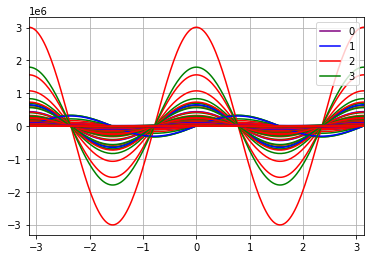

In [34]:
plot_andrews_curves(stradifiedSampleDF, targetFeature=targetFeature)

To use Andrew Curves we first format out dataframe by sorting the features in order of importance and then plot them. we used backward selection to do this. 

Each line in the plot is an entry in the stratified Sample and its color is its value in the Score Feature. 

The plot seems to suggest that there is some structure to this dataset.

It seems categories, Score = 2 and 3 have very little distinction between their entries. This means that The ML models will probably find it hard to distinquish the entries between the two, so it is likely that there will be some false positives and false negatives. 

It seems like entries with Score=1 has the most distinct curves from the rest of the categories. This probably means that it will be easier for the ML models to categorize entries with Score=1 and harder to distingish the rest of the  categories



Parallel coordinates plot is a useful tool for checking  if observations are distinguishable on the basis of a given feature

The parallel coordinates block allows to see clusters in data and to estimate other statistics visually. Each multivariate observation is represented (in parallel) by connected line segments

Each vertical line represents one feature and the points that tend to cluster will appear closer together. If there is a clear distinction between the colors in one feture then it is enough to use that feature to have the classification. 

Each line in the plot is an entry in the stratified Sample and its color is its value in the Score Feature. 






In [35]:
def plot_parallel_coordinates(Datagrame, targetFeature, maxFeatures):
  colors = ("purple","blue","red","green")
  df=Datagrame.copy()
  columns=list(find_most_important_attribute_names(df, maxFeatures ));
  columns.append(targetFeature)
  print(columns)
  df = df[columns]
  pdplt.parallel_coordinates(df, targetFeature,color=colors)
  plt.show()



initially
   RevolvingUtilizationOfUnsecuredLines  age  ...  NumberOfDependents  Score
0                              0.766127   45  ...                 2.0      0
1                              0.957151   40  ...                 1.0      1
2                              0.658180   38  ...                 0.0      0
3                              0.233810   30  ...                 0.0      2
4                              0.907239   49  ...                 0.0      0
5                              0.213179   74  ...                 1.0      3
6                              0.305682   57  ...                 0.0      3
7                              0.754464   39  ...                 0.0      1
8                              0.116951   27  ...                 0.0      2
9                              0.189169   57  ...                 2.0      2

[10 rows x 11 columns]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.5s finished

[2021-07-29 16:04:09] Features: 1/5 -- score: 0.49192[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.1s finished

[2021-07-29 16:04:14] Features: 2/5 -- score: 0.5112399999999999[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.0s finished

[2021-07-29 16:04:18] Features: 3/5 -- score: 0.5181000000000001[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 

   RevolvingUtilizationOfUnsecuredLines  age  ...  NumberOfDependents  Score
0                              0.766127   45  ...                 2.0      0
1                              0.957151   40  ...                 1.0      1
2                              0.658180   38  ...                 0.0      0
3                              0.233810   30  ...                 0.0      2
4                              0.907239   49  ...                 0.0      0
5                              0.213179   74  ...                 1.0      3
6                              0.305682   57  ...                 0.0      3
7                              0.754464   39  ...                 0.0      1
8                              0.116951   27  ...                 0.0      2
9                              0.189169   57  ...                 2.0      2

[10 rows x 11 columns]
   RevolvingUtilizationOfUnsecuredLines  age  ...  NumberOfDependents  Score
0                              0.766127   45  ...   

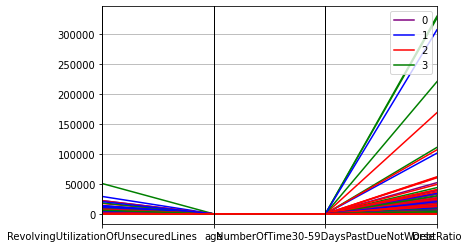

In [36]:
# if there is a feature where the lines of the same color seperate from the rest colors
# then that feature will be very usefull to distinguish that class from the others.

plot_parallel_coordinates(stradifiedSampleDF, targetFeature=targetFeature, maxFeatures=4)

We can see that there is a not feature where the lines of of the same color, are seperate from the rest so there is no one feature alone that can distinquish the categories. 

However It seems that RevolvingUtilizationOfsecuredLines and DebtRatio are  great indicators as to what category an entry might be in because of how more distinct those color are there.

##Some functions for visualization

In [37]:
from matplotlib import cm as cm

#checked
def make_heatmap_with_correlations(df,limit=10):
    #get correlations of each features in dataset
    corrmat = get_linear_correlations(df, interested_columns=[],sort_column_name=targetFeature) 
    num=0
    if("Id"in df.columns):
        num=num+1
    if("Score"in df.columns):
        num=num+1
    if(limit>=len(df.columns)-num):
        most_important_features=df.columns
    else:
        most_important_features=find_most_important_attribute_names(df,n=limit)
    plt.figure()

    #plot heat map
    corr=df[most_important_features].corr(method='pearson')
    cmap = cm.get_cmap('jet', 30)
    _, ax = plt.subplots( figsize = ( 12 , 10 ) )
    g=sns.heatmap(corr, cmap = cmap, square=True, cbar_kws={
                  'shrink' : .9 }, ax=ax, annot = True, annot_kws = {
                  'fontsize' : 12 }, xticklabels=corr.columns,
                  yticklabels=most_important_features)


    
def create_column_chart_all_columns(df,limit=10):
    num=0
    if("Id"in df.columns):
        num=num+1
    if("Score"in df.columns):
        num=num+1
    if(limit>=len(df.columns)-num):
        most_important_features=df.columns
    else:
        most_important_features=find_most_important_attribute_names(df,n=limit)
    temp=df[most_important_features]
    temp.plot.bar( align='center', alpha=0.5)


# def create_column_chart_2_columns(df, x_aksonas_column_name, y_aksonas_column_name):
#     plt.bar(df[x_aksonas_column_name], df[y_aksonas_column_name])
#     plt.xlabel(x_aksonas_column_name)
#     plt.ylabel(y_aksonas_column_name)
#     plt.show()
    

# def create_pie_chart(df, column_name,shadow=True,radius =1,
#                 labeldistance=1.1,pctdistance =0.6 ):
#     plt.pie(df[column_name],
#     autopct ='% 1.1f %%', shadow = shadow,radius =radius,
#            labeldistance =labeldistance,pctdistance =pctdistance  )
#     plt.show()


# def create_scatter_plot(df, x_aksonas_column_name, y_aksonas_column_name):
#     # scatter plot between income and age
#     plt.scatter(df[x_aksonas_column_name], df[y_aksonas_column_name])
#     plt.show()

# #option to
# # makes it much easier to visualize the places alpha
# # 0.1where there is a high density of data points
# def create_classsic_plot(column_x, column_y, column_name_x="x-axis",
#                          column_name_y="y-axis", scatter=False, alpha=None):
#     plt.xlabel(column_name_x)
#     plt.ylabel(column_name_y)
#     if (scatter == True):
#         plt.scatter(column_x, column_y,alpha=alpha)
#     else:
#         plt.plot(column_x, column_y,alpha=alpha)

        
# def create_scatter_plot_for_df(df,column_x_name, column_y_name,  alpha=None):
#     df.plot(kind="scatter", x=column_x_name, y=column_y_name, alpha=alpha)

# # The radius of each circle represents the value of radius_column(option s),
# # and the color represents the color_column (option c).
# # We will use a predefined color map (option cmap) called jet, which ranges from blue
# # (low values) to red (high prices)
# def advance_plot(df,column_x_name, column_y_name, radius_column_name,
#                          color_column, alpha=None):
#     df.plot(kind="scatter", x=column_x_name, y=column_y_name, alpha=alpha,
#                  s=df[radius_column_name], label=radius_column_name,
#                  c=color_column, cmap=plt.get_cmap("jet"), colorbar=True,
#                  )
#     plt.legend()



def make_scatter_plot_with_grouped_attributes(df,target_column_name, limit=10):
  categories= np.unique(df[target_column_name])
  y_column_name= targetFeature;
  num=0
  if("Id"in df.columns):
      num=num+1
  if("Score"in df.columns):
      num=num+1
  if(limit>=len(df.columns)-num):
      most_important_features=df.columns
  else:
      most_important_features=find_most_important_attribute_names(df,n=limit)
  for feature1 in most_important_features:
    for feature2 in most_important_features:
      if(feature1==feature2):
        continue
      create_color_category_depended_plot(df, feature1,feature2,categories,target_column_name)



def create_color_category_depended_plot(df, x_column,y_column,categories,target_column_name):
  colors = ("purple","blue","red","green")
  for index,category in enumerate(categories):
    tempDf=df[df[target_column_name]==category]
    plt.scatter(tempDf[x_column], tempDf[y_column],c=colors[index], )
  plt.xlabel(x_column)
  plt.ylabel(y_column)
  plt.show()

def find_correlations_through_scatter_matrix(df, maxFeatures=10):
    num=0
    if("Id"in df.columns):
        num=num+1
    if("Score"in df.columns):
        num=num+1
    if(maxFeatures>=len(df.columns)-num):
        most_important_features=df.columns
    else:
        most_important_features=list(find_most_important_attribute_names(df,n=maxFeatures))
        most_important_features.append(targetFeature)
    temp=df[most_important_features]

    pdplt.scatter_matrix(temp)
    plt.show()


def divide1DlistTo2D(columns,sizeOfInnerList):
    listOfColumns=[columns[i:i+sizeOfInnerList] for i in range(0, len(columns), sizeOfInnerList)]
    return listOfColumns



# box and whisker plots for whole dataframe
def createBoxAndWhiskerPlotForAllFeature(dataframe, sizeOfRow=3):
  columns=list(dataframe.columns)
  listOfColumns=divide1DlistTo2D(columns, sizeOfRow)
  for rowOfColumns in listOfColumns:
    dataframe[rowOfColumns].plot(kind='box', subplots=True)
    plt.show()
  
# box and whisker plots for one Feature
def createBoxAndWhiskerPlotForOneFeature(dataframe, nameOfColumn):
  dataframe[nameOfColumn].plot(kind='box', layout=(5,5), sharex=False, sharey=False)
  plt.show()
#A histogram shows the number of instances(on the vertical axis)
#that have a given value range (on the horizontal axis).
def create_histogram(df, figsize=None,limit=10,sizeOfRow=6):
    num=0
    if("Id"in df.columns):
        num=num+1
    if("Score"in df.columns):
        num=num+1
    if(limit>=len(df.columns)-num):
        most_important_features=df.columns
    else:
        most_important_features=find_most_important_attribute_names(df,n=limit)
    temp=df[most_important_features]

    columns=list(temp.columns)
    listOfColumns=divide1DlistTo2D(columns, sizeOfRow)
    for rowOfColumns in listOfColumns:
      temp[rowOfColumns].hist(column=rowOfColumns,figsize=figsize)
      plt.show()

def create_histogram_for_one_feature(dataframe, column_name):
  dataframe[column_name].hist()
  plt.show()


## Lets make a scatter plot of our data

initially
   RevolvingUtilizationOfUnsecuredLines  age  ...  NumberOfDependents  Score
0                              0.766127   45  ...                 2.0      0
1                              0.957151   40  ...                 1.0      1
2                              0.658180   38  ...                 0.0      0
3                              0.233810   30  ...                 0.0      2
4                              0.907239   49  ...                 0.0      0
5                              0.213179   74  ...                 1.0      3
6                              0.305682   57  ...                 0.0      3
7                              0.754464   39  ...                 0.0      1
8                              0.116951   27  ...                 0.0      2
9                              0.189169   57  ...                 2.0      2

[10 rows x 11 columns]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.5s finished

[2021-07-29 16:08:29] Features: 1/4 -- score: 0.49192[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.2s finished

[2021-07-29 16:08:33] Features: 2/4 -- score: 0.5112399999999999[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.0s finished

[2021-07-29 16:08:37] Features: 3/4 -- score: 0.5181000000000001[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 

   RevolvingUtilizationOfUnsecuredLines  age  ...  NumberOfDependents  Score
0                              0.766127   45  ...                 2.0      0
1                              0.957151   40  ...                 1.0      1
2                              0.658180   38  ...                 0.0      0
3                              0.233810   30  ...                 0.0      2
4                              0.907239   49  ...                 0.0      0
5                              0.213179   74  ...                 1.0      3
6                              0.305682   57  ...                 0.0      3
7                              0.754464   39  ...                 0.0      1
8                              0.116951   27  ...                 0.0      2
9                              0.189169   57  ...                 2.0      2

[10 rows x 11 columns]
   RevolvingUtilizationOfUnsecuredLines  age  ...  NumberOfDependents  Score
0                              0.766127   45  ...   

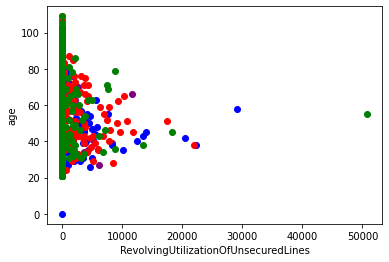

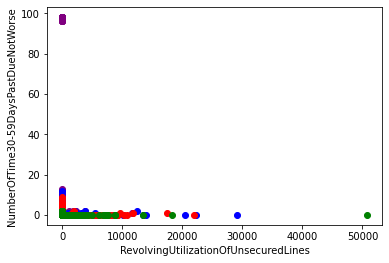

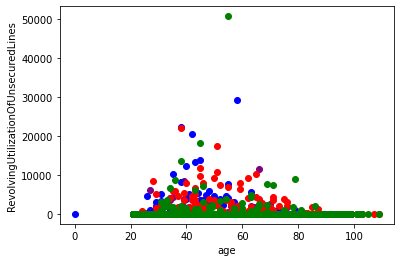

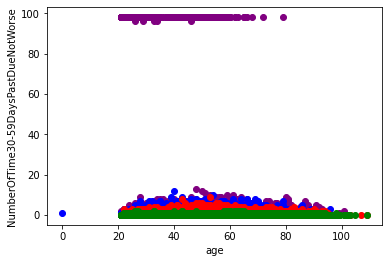

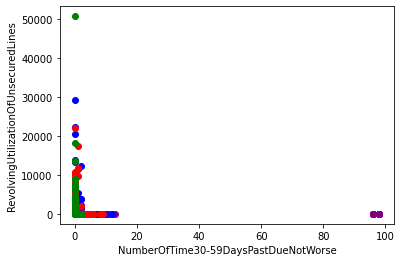

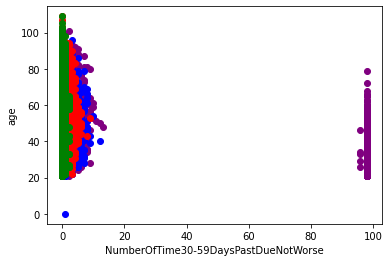

In [38]:
make_scatter_plot_with_grouped_attributes(oringinalDataset, targetFeature, limit=3)

## Lets continue by checking the distribution of the Data. 
## Box and whisper plots show how the data is spread out. 
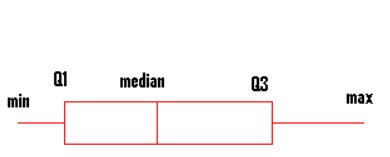

1. As you can see from the picture above the line on the bottom of the plot  represents the minimum value of the feature
2. the line on the top of the plot  represents the maximum value of the feature
3. the line on the middle  of the plot represents the median value of the feature
4. the line between the median and the min is the 25% 
5. the line between the median and the max is the 75% 
6. By extension the left box represents the values that are between the median and the 25% and the left the right box represents the values that are between the median and the 75% 
7. this means that 50% of all values are in the two boxes
8. The dots represents the outliers 

Box and whisper plots allow us to see the distribuition of the data with less detail than histograms.

We can see that if the distance between the 25% and the 75% is the same then it is resonable to concider that thsi feature might follow  normal distribuition

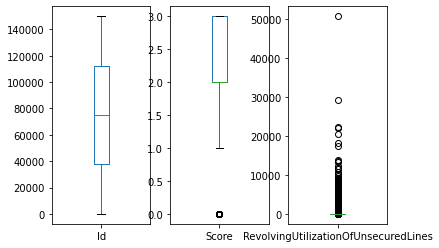

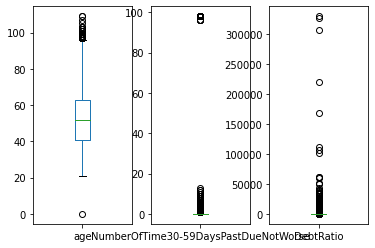

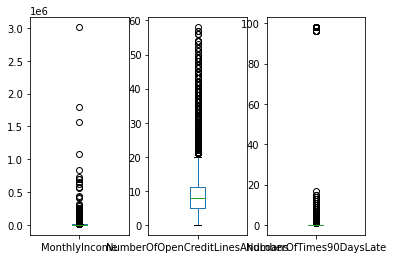

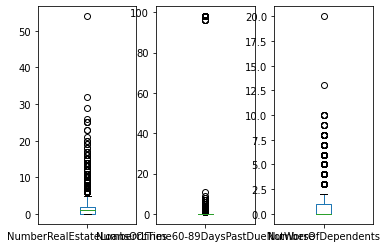

In [39]:
createBoxAndWhiskerPlotForAllFeature(oringinalDataset)

### Histograms show the distribution of the data in greater detail


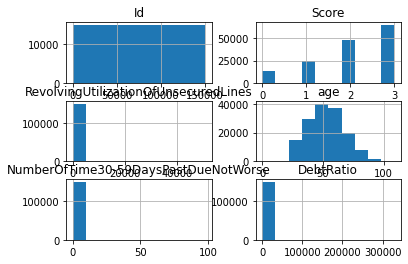

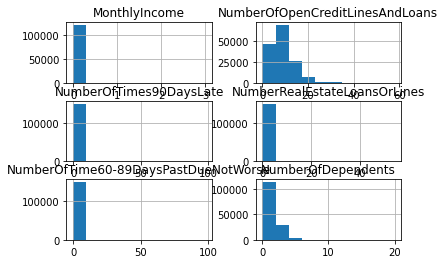

In [40]:
create_histogram(oringinalDataset, limit=len(oringinalDataset.columns))

Let's focus on the distribution of the features we hypothesised before that they might follow normal distribuition.

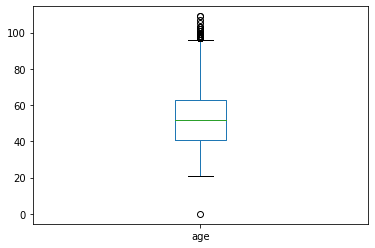

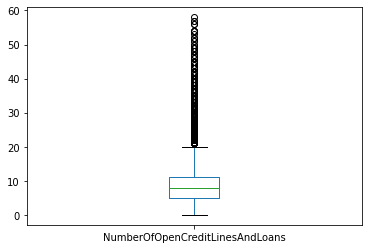

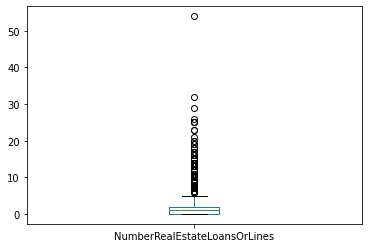

In [41]:
createBoxAndWhiskerPlotForOneFeature(oringinalDataset, "age")
createBoxAndWhiskerPlotForOneFeature(oringinalDataset, "NumberOfOpenCreditLinesAndLoans")
createBoxAndWhiskerPlotForOneFeature(oringinalDataset, "NumberRealEstateLoansOrLines")


# finalFeaturesDF["age"].plot(kind='box', layout=(5,5), sharex=False, sharey=False)
# plt.show()
# finalFeaturesDF["NumberOfOpenCreditLinesAndLoans"].plot(kind='box', layout=(5,5), sharex=False, sharey=False)
# plt.show()
# finalFeaturesDF["NumberRealEstateLoansOrLines"].plot(kind='box', layout=(5,5), sharex=False, sharey=False)
# plt.show()

This Plots show graphically what we have already seen in the describe method above. We can see that if the distance between the 25% and the 75% is the same so it is resonable to assume that this feature might follow normal distribuition

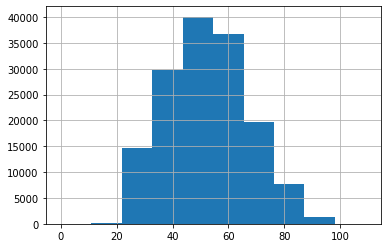

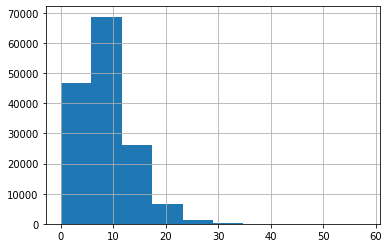

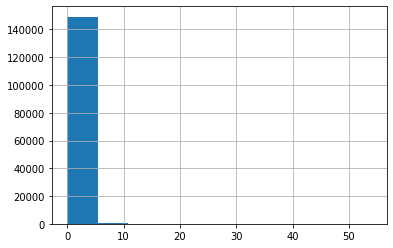

In [42]:
# histograms
create_histogram_for_one_feature(oringinalDataset, "age")
create_histogram_for_one_feature(oringinalDataset, "NumberOfOpenCreditLinesAndLoans")
create_histogram_for_one_feature(oringinalDataset, "NumberRealEstateLoansOrLines")


When we see the histogram of these features we get a clearer picture. 

The above graph clearly show that Age indeed follows normal distribution. This is easily undestood since the distribution of the data follow have a bell like shape.

The same can not be said about NumberRealEstateLoansOrLines and NumberOfOpenCreditLinesAndLoans because their distributions are more disproportionate. 

### Lets take a look at the interactions/correlations between features

#### Note the diagonal grouping of some pairs of attributes suggests a high correlation and a predictable relationship!

Two features are positivly correlated when the as the one increases the some is true for the other one and negativly correlated when as the one increases the other dicreases.

When Two fetures are correlated i can reomve one of them and the ML model will achieve the same performance in less time. 


initially
   RevolvingUtilizationOfUnsecuredLines  age  ...  NumberOfDependents  Score
0                              0.766127   45  ...                 2.0      0
1                              0.957151   40  ...                 1.0      1
2                              0.658180   38  ...                 0.0      0
3                              0.233810   30  ...                 0.0      2
4                              0.907239   49  ...                 0.0      0
5                              0.213179   74  ...                 1.0      3
6                              0.305682   57  ...                 0.0      3
7                              0.754464   39  ...                 0.0      1
8                              0.116951   27  ...                 0.0      2
9                              0.189169   57  ...                 2.0      2

[10 rows x 11 columns]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.4s finished

[2021-07-29 16:08:52] Features: 1/4 -- score: 0.49192[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.1s finished

[2021-07-29 16:08:56] Features: 2/4 -- score: 0.5112399999999999[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.0s finished

[2021-07-29 16:09:00] Features: 3/4 -- score: 0.5181000000000001[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 

   RevolvingUtilizationOfUnsecuredLines  age  ...  NumberOfDependents  Score
0                              0.766127   45  ...                 2.0      0
1                              0.957151   40  ...                 1.0      1
2                              0.658180   38  ...                 0.0      0
3                              0.233810   30  ...                 0.0      2
4                              0.907239   49  ...                 0.0      0
5                              0.213179   74  ...                 1.0      3
6                              0.305682   57  ...                 0.0      3
7                              0.754464   39  ...                 0.0      1
8                              0.116951   27  ...                 0.0      2
9                              0.189169   57  ...                 2.0      2

[10 rows x 11 columns]
   RevolvingUtilizationOfUnsecuredLines  age  ...  NumberOfDependents  Score
0                              0.766127   45  ...   

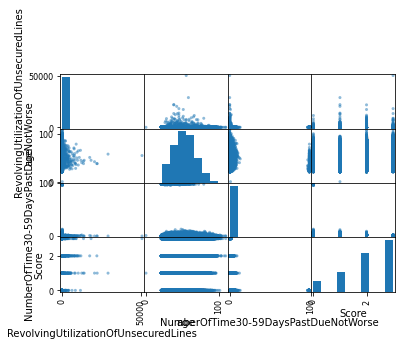

In [43]:
find_correlations_through_scatter_matrix(oringinalDataset, maxFeatures=3)

In [44]:
make_scatter_plot_with_grouped_attributes

<function __main__.make_scatter_plot_with_grouped_attributes>

A heatmap is a visual representation of how correlated each feature is with each other. 

It is very interesting to see that there are some features that are higly correlated with the tagrget feature. This will be more clear in the feature selection section of this nodebook.

<Figure size 432x288 with 0 Axes>

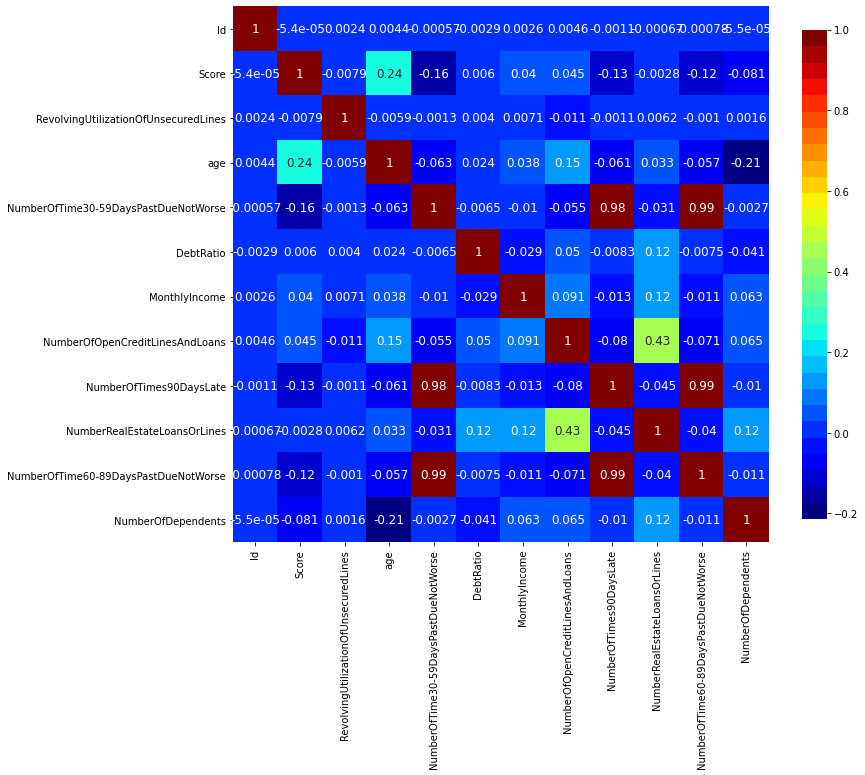

In [45]:
# from matplotlib import cm as cm

# plt.figure()
# corr = oringinalDataset.corr(method='pearson')
# cmap = cm.get_cmap('jet', 30)
# _, ax = plt.subplots( figsize = ( 12 , 10 ) )
# sns.heatmap(corr, cmap = cmap, square=True, cbar_kws={
# 'shrink' : .9 }, ax=ax, annot = True, annot_kws = {
# 'fontsize' : 12 }, xticklabels=corr.columns,
# yticklabels=corr.columns)

make_heatmap_with_correlations(oringinalDataset,limit=20)


#Section 3: Scaling the Data

Next we will Scale/ Normalize the Data. 

The reason we scale/ normalize the data is due to how the accuracy is measured. 

For Example if we use Least mean square Error the features with large values will have larger mean square error than those with smaller values. Since the ML model is trying to minimize the MSE it will undertand that the features with larger values are more important and the features with smaller values will "drawn out". 

The target value is not necessary to be scaled.

* MinMaxScaler Rescales each feature individually into the range [0, 1]

If our values have negatives values we might prefer to use MaxAbsScaler.

We need to be careful of the scale the data are already in. For example if the data is int some large logarithmic scale the differrence in the new range becomes too small so we lose the sense of scale.

If out Data follows Standard daviation then we should use StandardScaler

* StandardScaler Rescales each feature individually so that it follows normal distribution( have zero mean 𝜇 = 0 and unit variance 𝜎^2 = 1)

this method is not recommended for 
1. Data that don't follow normal distribuition 

2. sparse data because it destroys sparseness

3. Not recommended for data with extreme outliers

The above methods are sensitive to the presence of outliers. If we want to keep the outlier we might prefer to use RobustScaler. 

the centering and scaling statistics of RobustScaler is based on percentiles and are therefore not influenced by a few number of very large marginal outliers. 

finally there is the Binary scaling which Transform data to binary using a threshold

if values > threshold marked 1, values < threshold marked as 0

This is Useful when adding new ‘meaningful’ features.

###We chose to use minMax scaler because we don't have negative data and we concluded from our experience above that only one feature follows normal distribution. Also we have already removed the outliers so this is the ideal choice for us. 

We could have used StandardScaler to normalize the one feature but after consultiing with Dr Agathocleus we thought it was best to use one scaler for all data.

In [46]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro

def columnsToScale(df):
  lista=[]
  columnsToNotScale={ "Id","Score"}
  for feature in df.columns:
    if(feature not in columnsToNotScale ):
      lista.append(feature)
  return lista


def scaleDataFrame(df,nameOfScaler="MinMaxScaler"):
  new_df=df.copy()
  columnsToScaleList =columnsToScale(df)

  if (nameOfScaler=="RobustScaler"):
    scaler = RobustScaler().fit(new_df[columnsToScaleList])
  elif (nameOfScaler=="MinMaxScaler"):
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(new_df[columnsToScaleList])
  elif (nameOfScaler=="StandardScaler"):
    scaler = StandardScaler().fit(new_df[columnsToScaleList])
  
  new_df[columnsToScaleList] = scaler.fit_transform(new_df[columnsToScaleList])
  return new_df
  # new_df=df.copy()
  # scalers={}
  # for feature in df.columns:
  #   data=df[feature]
  #   # normality test
  #   stat, p = shapiro(data)
  #   print('Statistics=%.3f, p=%.3f' % (stat, p))
  #   # interpret
  #   alpha = 0.05
  #   if p > alpha:
  #     print("here!")
  #     scaler = StandardScaler().fit(data)
  #   else:
  #     scaler = MinMaxScaler(feature_range=(0, 1)).fit(data)
  #   new_df[feature]=scaler.transform(data)
  #   scalers[feature]=scaler;
  # return new_df, scalers


def scaleData(x_train, x_test, nameOfScaler="MinMaxScaler"):

  if (nameOfScaler=="RobustScaler"):
    scaler = RobustScaler().fit(x_train)
  elif (nameOfScaler=="MinMaxScaler"):
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(x_train)
  elif (nameOfScaler=="StandardScaler"):
    scaler = StandardScaler().fit(x_train)
  scaled_x_train=scaler.fit_transform(x_train)
  scaled_x_test=scaler.fit_transform(x_test)
  scaled_x_train, scaled_x_test
  


###As you see below. All have been normalized and the data is looking well


In [47]:
scaledDF=scaleDataFrame(df_without_outliers)
scaledDF.head()

,Id,Score,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,2,1,0.383680,0.253333,0.0,0.000020,0.082540,0.173913,0.0,0.00,0.0,0.25
2,3,0,0.263836,0.226667,0.2,0.000014,0.096571,0.086957,0.5,0.00,0.0,0.00
3,4,2,0.093724,0.120000,0.0,0.000006,0.104762,0.217391,0.0,0.00,0.0,0.00
5,6,3,0.085454,0.706667,0.0,0.000061,0.111111,0.130435,0.0,0.25,0.0,0.25
6,7,3,0.122535,0.480000,0.0,0.933464,0.171429,0.347826,0.0,0.75,0.0,0.00


###Here we see some stats about them

In [48]:
scaledDF.describe()

,Id,Score,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,142250.000000,142250.000000,142250.000000,142250.000000,142250.000000,142250.000000,142250.000000,142250.000000,142250.000000,142250.000000,142250.000000,142250.000000
mean,74981.304478,2.131522,0.125687,0.418014,0.044219,0.048697,0.190992,0.354750,0.027360,0.237462,0.024517,0.175334
std,43287.797371,0.944079,0.141317,0.198138,0.124304,0.140398,0.116855,0.199641,0.134047,0.232907,0.122245,0.259209
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37492.250000,2.000000,0.011498,0.266667,0.000000,0.000028,0.122222,0.217391,0.000000,0.000000,0.000000,0.000000
50%,75009.000000,2.000000,0.058547,0.413333,0.000000,0.000059,0.171429,0.347826,0.000000,0.250000,0.000000,0.000000
75%,112436.750000,3.000000,0.215397,0.560000,0.000000,0.000139,0.228571,0.478261,0.000000,0.500000,0.000000,0.250000
max,150000.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Model  logistic_reggresion_model  Achived score:  0.5764586994727592 

time needed to do crossvalidation:  8.083250045776367 


Model  gaussian_naive_bayes_model  Achived score:  0.5341388400702988 

time needed to do crossvalidation:  0.25150465965270996 


Model  decision_tree_classifier_model  Achived score:  0.7750439367311073 

time needed to do crossvalidation:  3.4563865661621094 


Model  support_vector_classification_model  Achived score:  0.14396309314586994 

time needed to do crossvalidation:  5.090054035186768 


Model  SGDClasifier_model  Achived score:  0.5404217926186291 

time needed to do crossvalidation:  3.40981125831604 


Model  random_forest_model  Achived score:  0.8021792618629174 

time needed to do crossvalidation:  90.66069412231445 


Model  XGBoost_model  Achived score:  0.8279349736379613 

time needed to do crossvalidation:  1035.675194978714 




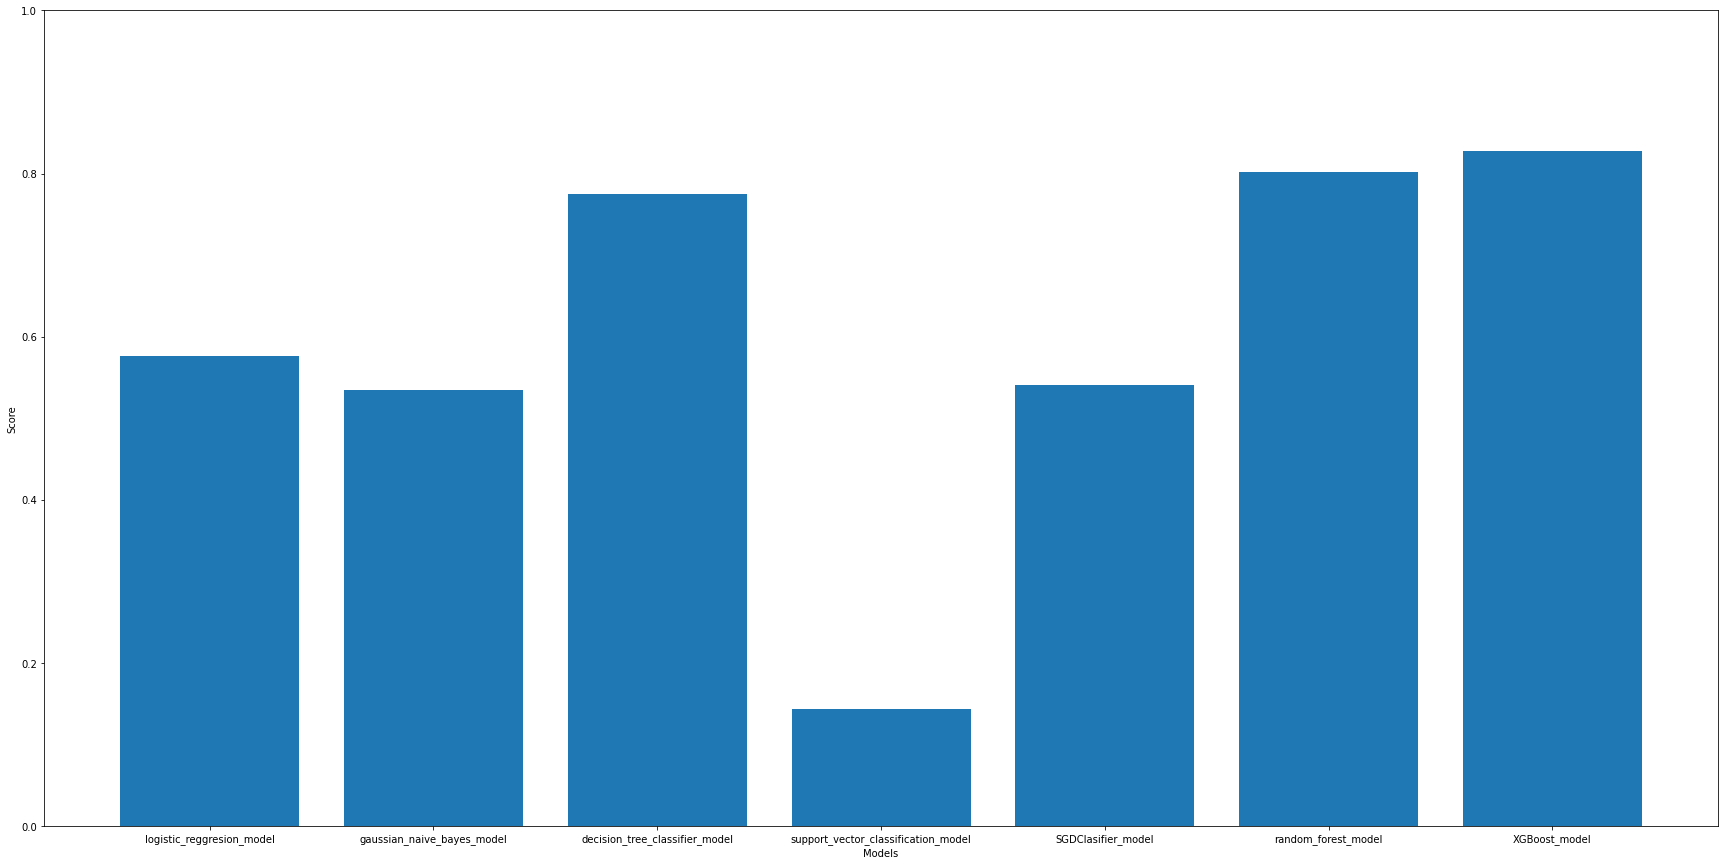

In [ ]:
getResultsOfCurrentDataframe(scaledDF,targetFeature= targetFeature, max_iterations=25)

As you can see, scaling heled the other models expect the forest once's who are also the best

#Section 4: Dimentionality Reduction

Here we reduce the dimensions (number of features) of our dataset. By removing features or combining features together to make something that has a higher correletion to our target.


For example if we were predicting the values of a house, then if we had the area of the house along with number of floors, number of bedrooms, baths and more.

Then that data alone would not help peredicting the price good enough. But if we had area/floors and numberOfBedrooms/numberOfBathrooms as collumns without the used features. Then it would show a much better correlation and make for better predictors.

This thus results in faster model training and testing, and better accuracy.

##The functions we are going to use

In [49]:
def find_columns(df, column_indexes):
    all_columns=df.columns
    new_columns=[]
    for index in column_indexes:
        new_columns.append(all_columns[index])
    return new_columns

#checked
def remove_features_with_low_variance(df):
    variances=df.var(axis=0)
    n=math.ceil((len(variances)/3))
    nsmallest=variances.nsmallest(n=n)
    threshold=nsmallest.mean()
    sel = VarianceThreshold(threshold=threshold)
    sel.fit_transform(df)
    column_indexes=sel.get_support(["index"])
    new_columns=find_columns(df,column_indexes)
    if("Score" not in new_columns):
        new_columns.append("Score")
    new_df=df[new_columns]
    return new_df

#checked
def SelectKBest_attributes(df,k=10,score_function=chi2):
    if(k>=len(df.columns)):
        return df
    X = df.iloc[:,0:-1]  #independent columns
    y = df.iloc[:,-1]    #target column i.e price range
    if("Id" in X.columns):
        X=X.drop("Id",axis=1)
    #apply SelectKBest class to extract top 10 best features
    bestfeatures = SelectKBest(score_func=score_function, k=k)
    bestfeatures.fit_transform(X,y)
    column_indexes=bestfeatures.get_support(["index"])
    new_columns=find_columns(df,column_indexes)
    if("Id" not in new_columns):
        new_columns.append("Id")
    if("Score" not in new_columns):
        new_columns.append("Score")
    new_df=df[new_columns]
    return new_df

    #checked
def l1_l2_based_feaure_selection(df, c=0.01,penalty="l1",sparse_estimator="lsvc"):
    X = df.iloc[:,0:-1]  #independent columns
    y = df.iloc[:,-1]    #target column i.e price range
    if(sparse_estimator=="lsvc"):
        lsvc = LinearSVC(C=0.01, penalty=penalty, dual=False).fit(X, y)
        model = SelectFromModel(lsvc, prefit=True)
        X_new = model.transform(X)
        
    else:
        lreg = LogisticRegression(C=0.01, penalty="l2", dual=False).fit(X, y)
        model = SelectFromModel(lreg, prefit=True)
        X_new = model.transform(X)
    column_indexes=model.get_support(["index"])
    new_columns=find_columns(df,column_indexes)
    if("Score" not in new_columns):
        new_columns.append("Score")
    new_df=df[new_columns]
    return new_df

def Tree_based_feature_selection(df,n_estimators=50):
    X = df.iloc[:,0:-1]  #independent columns
    y = df.iloc[:,-1]    #target column i.e price range
    clf = ExtraTreesClassifier(n_estimators=n_estimators)
    clf = clf.fit(X, y)
    model = SelectFromModel(clf, prefit=True)
    model.transform(X)
    column_indexes=model.get_support(["index"])
    new_columns=find_columns(df,column_indexes)
    if("Score" not in new_columns):
        new_columns.append("Score")
    new_df=df[new_columns]
    return new_df

#checked
def Recursive_feature_elimination_with_cross_validation(df,c=1.0):
    # Build a classification task using 3 informative features
    X = df.iloc[:,0:-1]  #independent columns
    y = df.iloc[:,-1]    #target column i.e price range
    # Create the RFE object and compute a cross-validated score.
    svc = SVC(C=c,kernel="linear")
    # The "accuracy" scoring is proportional to the number of correct
    # classifications
    rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
                  scoring='accuracy')
    rfecv.fit_transform(X, y)
    column_indexes=rfecv.get_support(["index"])
    new_columns=find_columns(df,column_indexes)
    if("Score" not in new_columns):
        new_columns.append("Score")
    new_df=df[new_columns]
    return new_df

#checked
def Recursive_feature_elimination(df,c=1.0):
    X = df.iloc[:,0:-1]  #independent columns
    y = df.iloc[:,-1]    #target column i.e price range

    # Create the RFE object and rank each pixel
    svc = SVC(C=c,kernel="linear")
    rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
    rfe.fit_transform(X, y)
    column_indexes=rfe.get_support(["index"])
    new_columns=find_columns(df,column_indexes)
    if("Score" not in new_columns):
        new_columns.append("Score")
    new_df=df[new_columns]
    return new_df


#NEEDS checking
# Forward selection
#start with a model with no features
# add a feature that maximizes criterion function
# repeat for all other features. 
# choose and add only the feature that had the best performance. 
# Now the model has one model, repat for from the third line. After doing it for all features then you add the second one. 
# finish when you reach desired number of features. 
from sklearn.naive_bayes import GaussianNB
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

def forwardSelection(df,NumberofFeatures=5, forward=True):
  X = df.iloc[:,0:-1]  #independent columns
  y = df.iloc[:,-1]    #target column i.e price range
  classifier =  GaussianNB()
  # Sequential Forward Selection
  sfs = SFS(classifier, 
            k_features=NumberofFeatures, 
            forward=forward, 
            floating=False, 
            verbose=2,
            scoring='accuracy',
            cv=10)

  sfs = sfs.fit(X, y)
  column_indexes=sfs.k_feature_idx_
  new_columns=find_columns(df,column_indexes)
  if("Score" not in new_columns):
      new_columns.append("Score")
  new_df=df[new_columns]
  return new_df

  
  # print('\nSequential Forward Selection (k=5):')
  # print('Selected features:',sfs.k_feature_idx_)
  # print('Prediction score:',sfs.k_score_)


  # backward selection
#start with a model with all features
# remove a feature that maximizes criterion function
# repeat for all other features. 
# choose and remove only the feature that made the least performance diference performance. 
# Now the model has -1 features model, repat for from the third line. After doing it for all features then you remove the second one
# finish when you reach desired number of features. 

# Example 2
# Sequential Backward Selection
def backwardSelection(df,NumberofFeatures=5):
  return forwardSelection(df,NumberofFeatures=NumberofFeatures, forward=True)



def select_features(df,k=None,c=0.1,list_of_eliminations=(1,1,1,1,1,1,1)):

    temp=df.to_dict()
    temp.pop("Id")
    temp["Score"]=temp.pop("Score")
    if(k==None):
      k=df.shape[1]-1
    new_df=pd.DataFrame(temp)
    print("initially\n"+ str(new_df.head(10)))
    if(list_of_eliminations[0]==1):
        new_df=remove_features_with_low_variance(new_df)
        print(new_df.head(10))
    if(list_of_eliminations[1]==1):
        new_df=l1_l2_based_feaure_selection(new_df,c=c)
        print(new_df.head(10))
    if(list_of_eliminations[2]==1):
      ##dont Use this one.
      print("Nothing")
        # new_df=l1_l2_based_feaure_selection(new_df,sparse_estimator="any",c=c)
    if(list_of_eliminations[3]==1):
        new_df=Tree_based_feature_selection(new_df)
        print(new_df.head(10))
    if(list_of_eliminations[4]==1):
        new_df=Recursive_feature_elimination(new_df,c*10)
        print(new_df.head(10))
    if(list_of_eliminations[5]==1):
        new_df=Recursive_feature_elimination_with_cross_validation(new_df,c*10)
        print(new_df.head(10))
    if(list_of_eliminations[6]==1):
        try:
            new_df=SelectKBest_attributes(new_df, k=k)
            print(new_df.head(10))
        except:
            print("could not do select k")
    if(list_of_eliminations[7]==1):
      try:
        backwardSelection(new_df, NumberofFeatures=k)
        print(new_df.head(10))
      except:
        print("could not do select k")
      
      print(new_df.head(10))

    ans=new_df
    if("Id"in df.columns):
        ans["Id"]=df["Id"]
        ans["Id"]=ans.pop("Id")
    if("Score"in df.columns):
        ans["Score"]=df["Score"]
        ans["Score"]=ans.pop("Score")
    return pd.DataFrame(ans)

def find_most_important_attribute_names(df,n=1):
    temp=setNAValuesInDataframeToMedian(df.copy())
    n=n+1
    temp=select_features(temp,list_of_eliminations=(0,0,0,0,0,0,0,1),k=n)
    if(n<=2):
        return temp.columns[0]
    else:
        return temp.columns[:n-1]
    

#The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that
# there is a strong positive correlation; When the coefficient is close to –1, it means
# that there is a strong negative correlation
# Finally, coefficients close to zero mean that there is no linear correlation.
# The correlation coefficient only measures linear correlations (“if x
# goes up, then y generally goes up/down”). It may completely miss
# out on nonlinear relationships
def get_linear_correlations(df, interested_columns=[],sort_column_name=None ):
    corr_matrix = df.corr()
    if(len(interested_columns)==0):
        if(sort_column_name!=None): 
            corr_matrix.sort_values(by=sort_column_name,ascending=True)
        return corr_matrix
    else:
        ans=corr_matrix[interested_columns]
        return ans
    
def helperFunction(column,threshold, columns_that_dont_find_corelation):
  set_of_correlated_columns=set() 
  for index in column.index:
    # print(index)
    if(index in columns_that_dont_find_corelation ):
        continue
    if(column[index]>threshold):
        set_of_correlated_columns.add(index)
    elif(column[index]<(-threshold)):
        set_of_correlated_columns.add(index)
  return set_of_correlated_columns



def merge_highly_correlated_columns(df,columns_that_dont_find_corelation=["Id"],
                            threshold=0.83):
    temp=df.copy()
    corr_matrix=get_linear_correlations(df,df.columns)
    # print(corr_matrix)
    to_remove=set()
    for column_name in corr_matrix.columns:
        if(column_name in columns_that_dont_find_corelation):
            continue
        # column=corr_matrix[column_name].drop(column_name)
        column=corr_matrix[column_name].drop(column_name)
        tempSet=helperFunction(column,threshold,columns_that_dont_find_corelation)
        if(len(tempSet)>0):
          tempSet.add(column_name)
          tempList=list(tempSet)
          tempList.sort()
          nameInSet=tempList[0]
          for column_name in tempList[1:]:
            nameInSet+=","+column_name
          to_remove.add(nameInSet)
    to_remove_columns=set()
    for tempString in to_remove:
      tempList=tempString.split(",")
      print(tempList)
      new_column_name=tempList[0]
      value=temp[tempList[0]]
      to_remove_columns.add(tempList[0])
      for column_name in tempList[1:]:
        new_column_name+= column_name+ "_plus_"
        value+=temp[column_name]
        to_remove_columns.add(column_name)
      temp[new_column_name]=value
    temp=temp.drop(to_remove_columns,axis=1)      

    return temp



def check_for_correlations_visually(df,promising_column_names):
    from pandas.plotting import scatter_matrix
    scatter_matrix(df[promising_column_names], figsize=(df.shape[0], 3*len(promising_column_names)),grid=True)


In [50]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def linearDiscriminantAnalysis(df, componentsNum=None, columnsToDrop=["Id"]):
  tempDF=df.copy();
  tempDF.drop(columnsToDrop, axis=1)
  lda = LinearDiscriminantAnalysis(n_components=componentsNum)
  X = tempDF.drop(targetFeature, axis=1)  #independent columns
  y = tempDF[targetFeature]    #target column i.e price range



  lda_data = lda.fit(X, y).transform(X)
  print(lda_data.shape)
  print(X.shape)
  # for feature in lda_data:
  #   print(feature)
  # print(str(lda.get_support(["index"])))
  # Percentage of variance explained for each components
  print('LDA explained variance ratio (first two components): %s'
        % str(lda.explained_variance_ratio_))
    # new_df=df[new_columns]
  getResultsOfCurrentDataframe(None,targetFeature= targetFeature,X=X, Y=y,  max_iterations=25)


##We have implemented multiple ways of reducing dimentions of the problem 
These Methods belong to 3 categories:
1. Removal of features
2. Merging Features
3. Project features into new Dimentions such that they Optimize Categorization. 

In [51]:
def bringUpToSpeed(dataset):
    columnsThatShouldNotHvaNegativeValues=set(["RevolvingUtilizationOfUnsecuredLines",
    "age"                                 ,    
    "NumberOfTime30-59DaysPastDueNotWorse", 
    "MonthlyIncome"                          , 
    "NumberOfOpenCreditLinesAndLoans"        , 
    "NumberOfTimes90DaysLate"                , 
    "NumberRealEstateLoansOrLines"           , 
    "NumberOfTime60-89DaysPastDueNotWorse"   , 
    "NumberOfDependents"
    ])
    columnsThatShouldNotHvaNegativeValues=columnsThatShouldNotHvaNegativeValues- set(np.setdiff1d(oringinalDataset.columns,dataset.columns))
    dataset[dataset[columnsThatShouldNotHvaNegativeValues]<0]=np.nan
    dataset= setNAValuesInDataframeToMedian(dataset)
    indexes_of_not_outliers=detect_and_remove_outliers_for_all_columns(oringinalDataset, methodName="both",threshold =4.5, lowPercent=5, upperPercent=95, get_indexes_of_not_outliers=True)
    dataset=dataset[dataset.index.isin(indexes_of_not_outliers)]
    dataset=scaleDataFrame(dataset)
    return dataset



  

In [52]:
featuresMerged =merge_highly_correlated_columns(oringinalDataset, columns_that_dont_find_corelation=["Id","Score"],
                            threshold=0.8) #Maybe en xriazete na to treksis tuto. Check again.





['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate']


<Figure size 432x288 with 0 Axes>

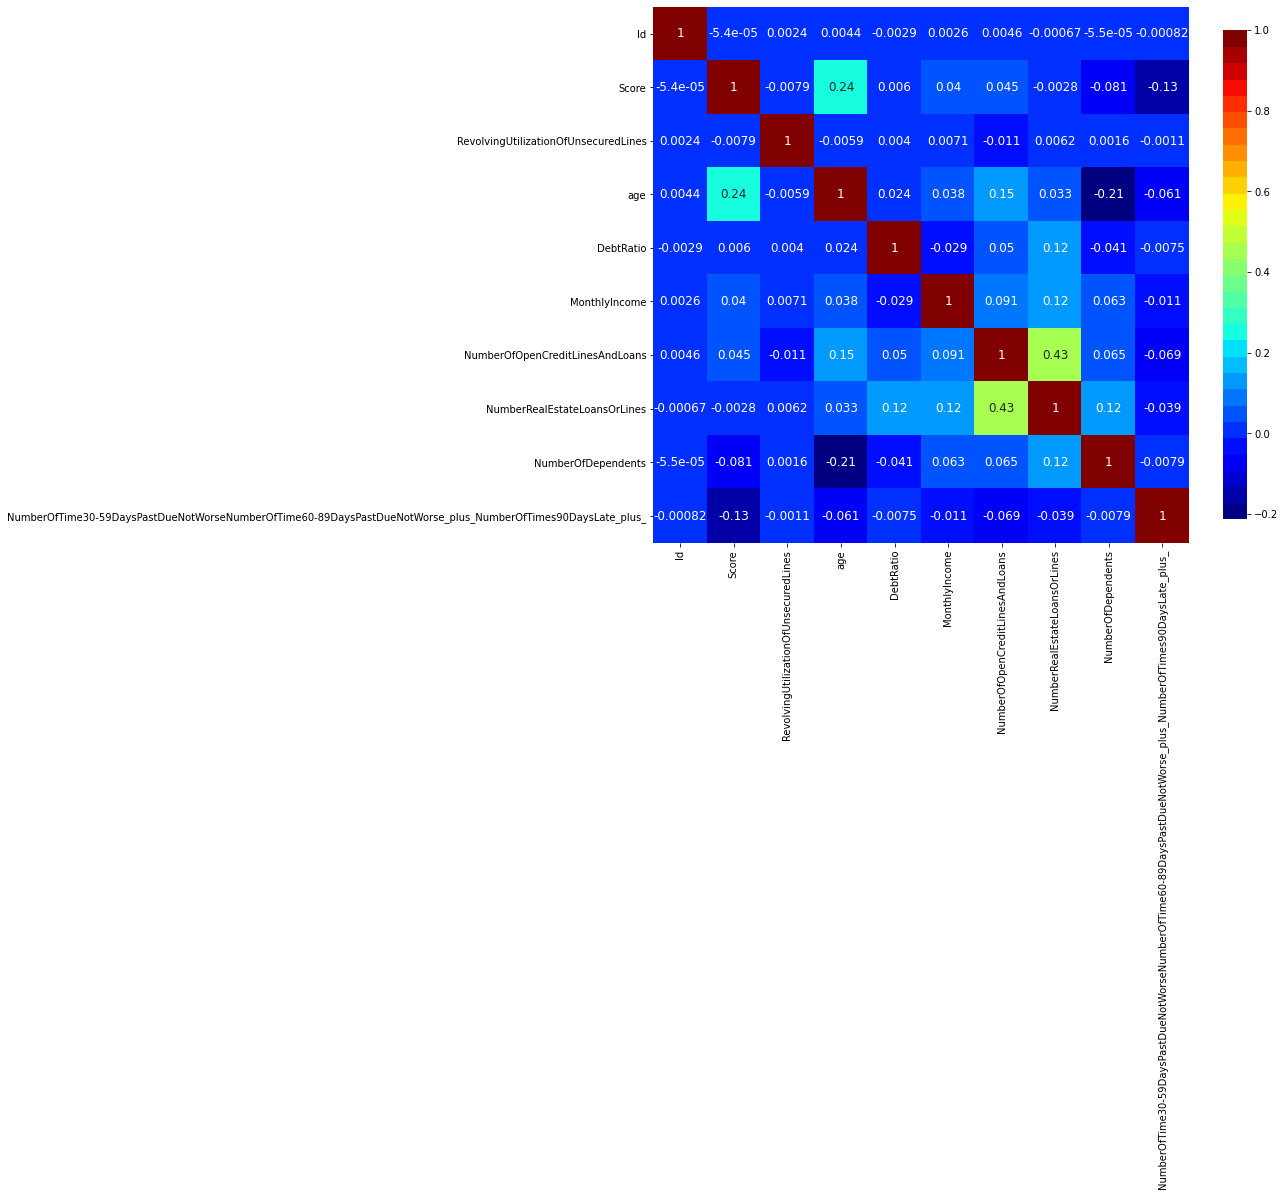

In [53]:
make_heatmap_with_correlations(featuresMerged, limit=len(featuresMerged.columns)+100)

In [54]:
featuresMerged= bringUpToSpeed(featuresMerged)

number of outliers  4213


In [55]:
print(len(featuresMerged.columns))
print(len(oringinalDataset.columns))
np.setdiff1d(oringinalDataset.columns,featuresMerged.columns)

10
12


array(['NumberOfTime30-59DaysPastDueNotWorse',
       'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'],
      dtype=object)

As you see it merged those 3 collumns to 1!

In [56]:
featuresMerged.columns

Index(['Id', 'Score', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
       'NumberRealEstateLoansOrLines', 'NumberOfDependents',
       'NumberOfTime30-59DaysPastDueNotWorseNumberOfTime60-89DaysPastDueNotWorse_plus_NumberOfTimes90DaysLate_plus_'],
      dtype='object')

In [ ]:
getResultsOfCurrentDataframe(featuresMerged,targetFeature= targetFeature, max_iterations=25)

Model  logistic_reggresion_model  Achived score:  0.5675174884086217 

time needed to do crossvalidation:  7.848720550537109 


Model  gaussian_naive_bayes_model  Achived score:  0.5698839747430038 

time needed to do crossvalidation:  0.24421024322509766 


Model  decision_tree_classifier_model  Achived score:  0.7581647637718755 

time needed to do crossvalidation:  3.3081836700439453 


Model  support_vector_classification_model  Achived score:  0.17869548086725281 

time needed to do crossvalidation:  4.615633726119995 


Model  SGDClasifier_model  Achived score:  0.5378594231590839 

time needed to do crossvalidation:  2.7433571815490723 


Model  random_forest_model  Achived score:  0.7833643481336671 

time needed to do crossvalidation:  78.29529452323914 




KeyboardInterrupt: ignored

In [57]:
featureSelectedDF=select_features(featuresMerged,k=len(featuresMerged.columns), list_of_eliminations=(1,1,1,0,0,0,0,1) )

featureSelectedDF.shape

initially
   RevolvingUtilizationOfUnsecuredLines  ...  Score
0                              0.307107  ...      0
1                              0.383680  ...      1
2                              0.263836  ...      0
3                              0.093724  ...      2
4                              0.363673  ...      0
5                              0.085454  ...      3
6                              0.122535  ...      3
7                              0.302432  ...      1
8                              0.046880  ...      2
9                              0.075830  ...      2

[10 rows x 9 columns]
   RevolvingUtilizationOfUnsecuredLines       age  ...  NumberOfDependents  Score
0                              0.307107  0.412844  ...                 0.4      0
1                              0.383680  0.366972  ...                 0.2      1
2                              0.263836  0.348624  ...                 0.0      0
3                              0.093724  0.275229  ...             

(145787, 8)

In [58]:
print(len(featureSelectedDF.columns))
print(len(featuresMerged.columns))
np.setdiff1d(featuresMerged.columns,featureSelectedDF.columns)

8
10


array(['MonthlyIncome',
       'NumberOfTime30-59DaysPastDueNotWorseNumberOfTime60-89DaysPastDueNotWorse_plus_NumberOfTimes90DaysLate_plus_'],
      dtype=object)

In [59]:
featureSelectedDF.describe()

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,Id,Score
count,145787.000000,145787.000000,145787.000000,145787.000000,145787.000000,145787.000000,145787.000000,145787.000000
mean,0.125460,0.480717,0.048527,0.270535,0.164432,0.145112,74979.748153,2.125992
std,0.140893,0.135855,0.140841,0.159292,0.165821,0.215784,43298.161500,0.945113
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.011601,0.376147,0.000029,0.161290,0.000000,0.000000,37479.500000,2.000000
50%,0.058893,0.477064,0.000059,0.258065,0.166667,0.000000,74982.000000,2.000000
75%,0.214332,0.577982,0.000137,0.354839,0.333333,0.200000,112442.500000,3.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,150000.000000,3.000000


As you see, it removed an additional 2 features , Monthly income and the merged collumns.

In [60]:
featureSelectedDF.shape

(145787, 8)

Model  logistic_reggresion_model  Achived score:  0.5093501584650536 

time needed to do crossvalidation:  7.614867210388184 


Model  gaussian_naive_bayes_model  Achived score:  0.5123339739572722 

time needed to do crossvalidation:  0.22479510307312012 


Model  decision_tree_classifier_model  Achived score:  0.5607524407992627 

time needed to do crossvalidation:  2.829416275024414 


Model  support_vector_classification_model  Achived score:  0.1515578314507481 

time needed to do crossvalidation:  4.282500267028809 


Model  SGDClasifier_model  Achived score:  0.49139583988684 

time needed to do crossvalidation:  2.4450602531433105 


Model  random_forest_model  Achived score:  0.6421473299049707 

time needed to do crossvalidation:  82.51572775840759 


Model  XGBoost_model  Achived score:  0.6325442452791089 

time needed to do crossvalidation:  848.2521395683289 




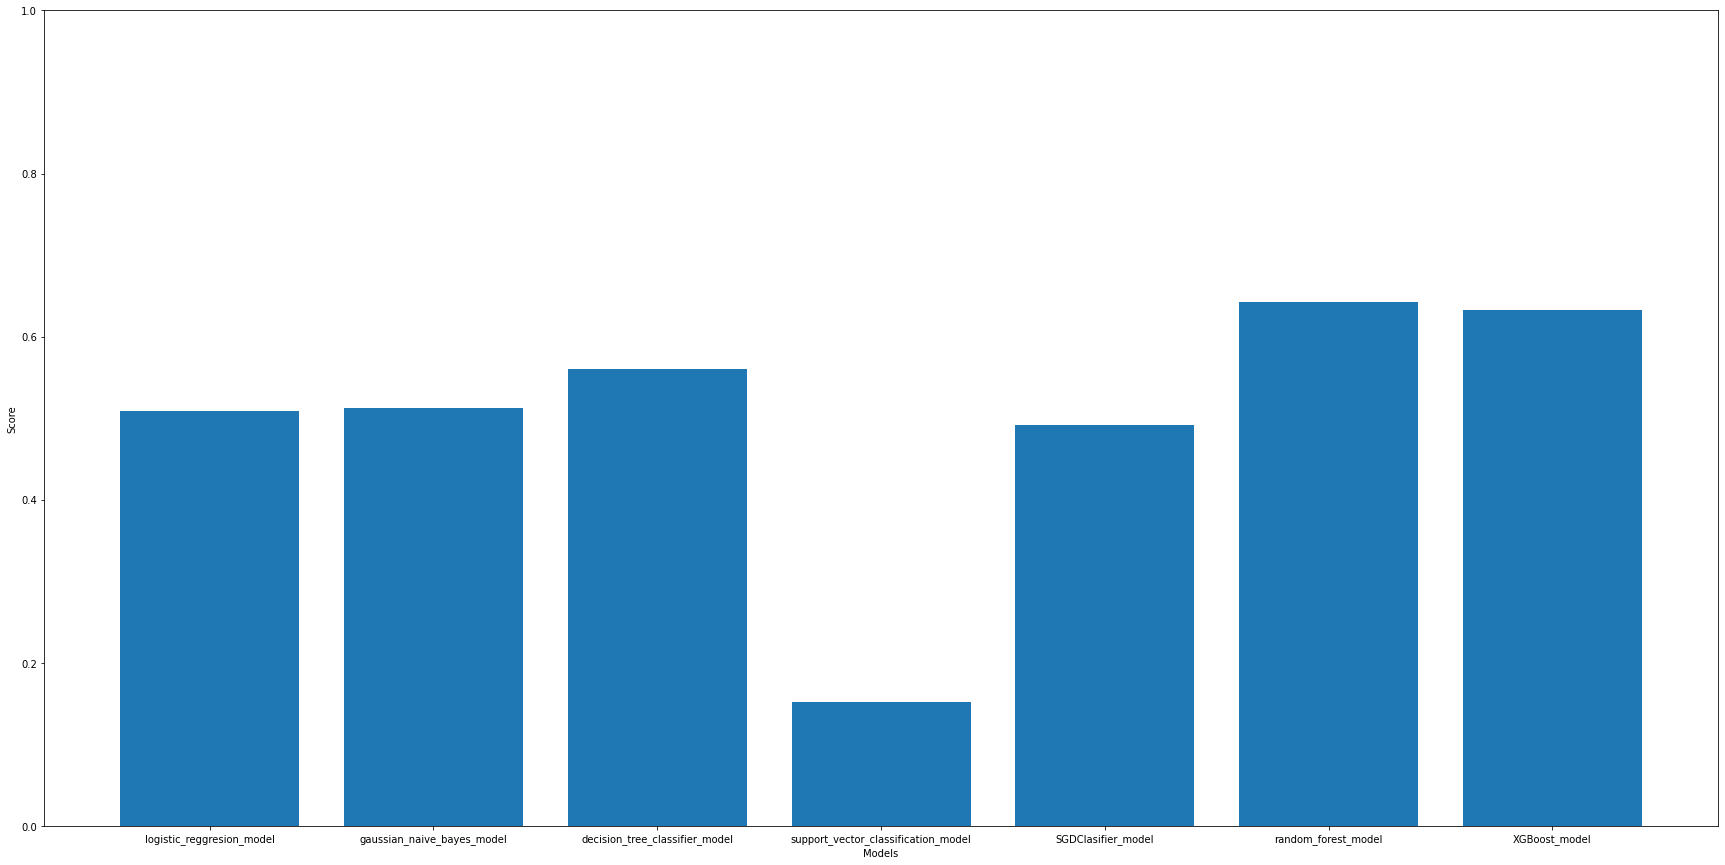

In [ ]:
getResultsOfCurrentDataframe(featureSelectedDF,targetFeature= targetFeature, max_iterations=25)

##Feature EXTRACTION



In [61]:
linearDiscriminantAnalysis(scaledDF)

(142250, 3)
(142250, 11)
LDA explained variance ratio (first two components): [0.88655875 0.09112204 0.02231921]
Model  logistic_reggresion_model  Achived score:  0.44425307557117744 

time needed to do crossvalidation:  4.566062688827515 


Model  gaussian_naive_bayes_model  Achived score:  0.44425307557117744 

time needed to do crossvalidation:  0.31831789016723633 


Model  decision_tree_classifier_model  Achived score:  0.7623374340949033 

time needed to do crossvalidation:  5.143195629119873 


Model  support_vector_classification_model  Achived score:  0.21158172231985942 

time needed to do crossvalidation:  5.859636068344116 


Model  SGDClasifier_model  Achived score:  0.2151493848857645 

time needed to do crossvalidation:  8.375787496566772 


Model  random_forest_model  Achived score:  0.7834094903339193 

time needed to do crossvalidation:  118.68009901046753 




KeyboardInterrupt: ignored

After careful testing of the above methods we decided that we would not be using any of them because the accuracy is actually decreasing when we remove a feature.

Our Dataset already has very few fetures, only 11 (without the ID) so these information are all needed for the model to have the best prediction. 

##These are the functions

In [62]:
# One way to compare classifiers is to measure the area under the curve (AUC).
# A perfectclassifier will have a ROC AUC equal to 1, whereas a purely random classifier will
# have a ROC AUC equal to 0.5. 
def get_optimal_hyperparamteres_of_model_usig_grid_search (model,data,
    labels, param_grid, cv=5,scoring='f1',get_estimator=False):
    grid_search = GridSearchCV(model, param_grid, cv=cv,scoring=scoring)
    grid_search.fit(data, labels)
    if(get_estimator==False):
        return grid_search.best_params_
    else:
        return grid_search.best_estimator_

from sklearn.model_selection import RandomizedSearchCV
def get_optimal_hyperparamteres_of_model_using_randomized_search_CV (model,
    data,labels, param_grid, cv=5,scoring='f1',
    get_estimator=False):
    grid_search = RandomizedSearchCV(model, param_grid, cv=cv,
                        scoring=scoring,random_state=42)
    grid_search.fit(data, labels)
    if(get_estimator==False):
        return grid_search.best_params_
    else:
        return grid_search.best_estimator_

In [63]:
def display_scores(scores,median_tora,mean_tora,std_tora,fkati_tora):
    print("Scores:", scores)
    print("Median", median_tora)
    print("Mean:", mean_tora)
    print("Standard deviation:", std_tora)
    print("fkati:", fkati_tora)


#default scoring method should probably change giaa binary classification model.
from sklearn.model_selection import StratifiedKFold
def show_comparison_of_models_using_cross_validation(models,data,labels,
    scoring_method="f1",cv=5,column_category_name="Score",weight_of_median=0.5):
    
    
    best_mean_index=0
    best_mean=None
    best_std_index=0
    best_std=None
    best_median_index=0
    best_median=None
    best_fkati=0
    best_fkati_index=None
    for i,model in enumerate(models):
        scores = cross_val_score(model, data, labels,
        scoring=scoring_method, cv=cv)
#         rmse_scores = np.sqrt(scores)
        rmse_scores = scores

        median_tora=np.median(rmse_scores)
        mean_tora=rmse_scores.mean()
        std_tora=rmse_scores.std()
        fkati_tora=  (((1-weight_of_median)*mean_tora)+ (weight_of_median*median_tora))/std_tora
#         display_scores(rmse_scores,median_tora,
#                      mean_tora,std_tora,fkati_tora )
        if(best_mean==None or best_mean<mean_tora ):
            best_mean=mean_tora
            best_mean_index=i
        if(best_std==None or best_std>std_tora ):
            best_std=std_tora
            best_std_index=i
        if(best_median==None or best_median<median_tora ):
            best_median=median_tora
            best_median_index=i
        if(best_fkati==None or best_fkati<fkati_tora):
            best_fkati=fkati_tora
            best_fkati_index=i
            
    print("best_median ",best_median,"was with model ",best_median_index,
          "best mean ",best_mean,"was with model ",best_mean_index,
          "best_std ",best_std,"was with model ",best_std_index,
         "best_fkati ",best_fkati,"was with model ", best_fkati_index)
    
    return best_fkati_index
    
def find_most_important_attribute_names(df,n=1):
    temp=df.copy()
    n=n+1
    temp=select_features(s,list_of_eliminations=(0,0,0,0,0,0,1),k=n)
    if(n<=2):
        return temp.columns[0]
    else:
        return temp.columns[:n-1]

  
from sklearn.metrics import classification_report
def find_classifiction_report(predictions,y_test):
    report=classification_report(y_test, predictions,output_dict=True)
    return report

# Section 5:  Fine tuning Hyperparameters
These are functions that finds the optimal hyperparameters of the models we saw though out this notebook with the final verison of the data

###The fucntions we will use

In [64]:
def create_logistic_regression_model(x_train,y_train):
    # all parameters not specified are set to their defaults
    logisticRegr = LogisticRegression()
    param_grid=dict(C=[0,2,0.5,0.8],
    penalty=["l1", "l2", "elasticnet"],random_state=[42],max_iter=[20,50,100,150,200,250])
    best_estimator=get_optimal_hyperparamteres_of_model_using_randomized_search_CV (model=logisticRegr,
    data=x_train,labels=y_train, param_grid=param_grid, cv=cv,scoring='accuracy',
    get_estimator=True)
    best_estimator.fit(x_train, y_train)
    return best_estimator

def create_k_neighbors_classifier_model(x_train,y_train,n_neighbors=5):
    neigh = KNeighborsClassifier()
    param_grid=dict(weights=["uniform", "distance"],p=[1,2],leaf_size=[10,20,30,40,50,60,80,100],
                   n_jobs=[1,2,3,4],metric=["minkowski","euclidean","manhattan","chebyshev"],
                   algorithm=["auto","ball_tree","kd_tree"])
    best_estimator=get_optimal_hyperparamteres_of_model_using_randomized_search_CV (model=neigh,
    data=x_train,labels=y_train, param_grid=param_grid, cv=cv,scoring='accuracy',
    get_estimator=True)
    best_estimator.fit(x_train, y_train)
    return best_estimator

def create_gaussian_naive_bayes_model(x_train,y_train,max_depth=None,
                                     max_features=10):
    gnb = GaussianNB()
    param_grid=dict()
    best_estimator=get_optimal_hyperparamteres_of_model_using_randomized_search_CV (model=gnb,
    data=x_train,labels=y_train, param_grid=param_grid, cv=cv,scoring='accuracy',
    get_estimator=True)
    best_estimator.fit(x_train, y_train)
    return best_estimator
                                      

def create_decision_tree_classifier_model(x_train,y_train):
    clf = DecisionTreeClassifier(random_state=0)
    param_grid=dict(criterion=["gini","entropy"],splitter=["best"],
                  max_depth=[300,650,1000,None],min_samples_split=[1,2,3,5,8],
                   max_features=["auto","sqrt","log2",None],
                   random_state=[42],class_weight=["balanced",None])
    best_estimator=get_optimal_hyperparamteres_of_model_using_randomized_search_CV (model=clf,
    data=x_train,labels=y_train, param_grid=param_grid, cv=cv,scoring='accuracy',
    get_estimator=True)
    best_estimator.fit(x_train, y_train)
    return best_estimator

def create_support_vector_classification_model(x_train, y_train):
    svc=SVC()
    param_grid=dict(C=[0.5,0.8,1,1.5,2,2.5],kernel=["linear","poly","rbf",
        "sigmoid" ],degree=[2,3,4],gamma=["scale","auto"],
        class_weight=["balanced",None],decision_function_shape=["ovo","ovr"],
                   break_ties=[True,False],random_state=[42])
    best_estimator=get_optimal_hyperparamteres_of_model_using_randomized_search_CV (model=svc,
    data=x_train,labels=y_train, param_grid=param_grid, cv=cv,scoring='accuracy',
    get_estimator=True)
    clf = make_pipeline(StandardScaler(), best_estimator)
    clf.fit(x_train, y_train)
    return clf


def create_SGDClasifier_model(x_train,y_train ):
    sgdc=SGDClassifier()
    param_grid=dict(loss=["hinge","log", "modified_huber", "squared_hinge", "perceptron"],
            penalty=["l1","l2"],alpha=[0.00005,0.0001,0.00015,0.0002,0.0003,0.001],
                    fit_intercept=[True],max_iter=[500,1000,1500,2000],epsilon=[0.05,0.1,0.2],
                     n_jobs=[1,2,3,4],learning_rate=["optimal"],warm_start=[False,True],
                    class_weight=["balanced",None],power_t=[0.2,0.4,0.5,0,7,0.9])
    best_estimator=get_optimal_hyperparamteres_of_model_using_randomized_search_CV (model=sgdc,
    data=x_train,labels=y_train, param_grid=param_grid, cv=cv,scoring='accuracy',
    get_estimator=True)
    clf = make_pipeline(StandardScaler(),best_estimator)
    clf.fit(x_train, y_train)
    return clf
    
def create_random_forest_model(x_train,y_train,n_estimators=100,
                max_depth=None):
    clf = RandomForestClassifier(max_depth=max_depth,n_estimators=n_estimators,
                                 random_state=42)
    param_grid=dict(n_estimators=[50,100,150,200,250],criterion=["gini","entropy"],
                  max_depth=[300,650,1000,None],min_samples_split=[1,2,3,5,8],
                   max_features=["auto","sqrt","log2",None],oob_score=[False,True],
                   random_state=[42],class_weight=["balanced",None],n_jobs=[1,2,3,4],
                   )
    best_estimator=get_optimal_hyperparamteres_of_model_using_randomized_search_CV (model=clf,
    data=x_train,labels=y_train, param_grid=param_grid, cv=cv,scoring='accuracy',
    get_estimator=True)
    best_estimator.fit(x_train, y_train)
    return best_estimator
def create_XGBClassifier_model(x_train,y_train):
    # all parameters not specified are set to their defaults
    model = XGBClassifier()
    param_grid=dict(
                    max_depth=[15],
                    learning_rate=[0.15,0.2,0.25,0.3],
                    n_estimators=[110,120,130],
                    objective=['multi:softmax'],
                    booster=["gbtree", "gblinear", "dart"],
                    n_jobs=[-1],
                    reg_alpha=[0.1, 0.2,0.3],
                    reg_lambda=[1, 0.7]
                    # random_state=[42]
    )


    best_estimator=get_optimal_hyperparamteres_of_model_using_randomized_search_CV (model=model,
    data=x_train,labels=y_train, param_grid=param_grid, cv=cv,scoring='accuracy',
    get_estimator=True)
    best_estimator.fit(x_train, y_train)
    return best_estimator

# this one actually tries possible combinations at random protimas to.
def get_optimal_hyperparamteres_of_model_using_randomized_search_CV (model,
    data,labels, param_grid, cv=5,scoring='accuracy',
    get_estimator=False):
    grid_search = RandomizedSearchCV(model, param_grid, cv=cv,
                        scoring=scoring, n_jobs=-1,n_iter=15)
    grid_search.fit(data, labels)
    if(get_estimator==False):
        return grid_search.best_params_
    else:
        return grid_search.best_estimator_
from sklearn.metrics import classification_report
def find_classifiction_report(predictions,y_test):
    report=classification_report(y_test, predictions,output_dict=True)
    return report

###Lets create the training and test sets

In [65]:
# smalldf=np.array_split(featureSelectedDF, 50)[0]
smalldf=scaledDF
# smalldf=featureSelectedDF
# smalldf=featuresMerged


In [66]:
X = smalldf.drop(columns=['Id','Score'],axis=1)
Y = smalldf['Score']

In [67]:
Y.shape

(142250,)

In [68]:

x_train, x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,stratify=Y, random_state=42)


In [69]:
# cv=None;
# logistic_reggresion_model=create_logistic_regression_model(x_train,y_train)
# logistic_reggresion_model
# k_neighbors_classifier_model=create_k_neighbors_classifier_model(x_train,y_train)
# k_neighbors_classifier_model
# gaussian_naive_bayes_model=create_gaussian_naive_bayes_model(x_train,y_train)
# gaussian_naive_bayes_model
# decision_tree_classifier_model=create_decision_tree_classifier_model(x_train,y_train)
# decision_tree_classifier_model
# support_vector_classification_model=create_support_vector_classification_model(x_train,y_train)
# support_vector_classification_model
# SGDClasifier_model=create_SGDClasifier_model(x_train,y_train)
# SGDClasifier_model
# random_forest_model=create_random_forest_model(x_train,y_train)
# random_forest_model
# models=[
#     logistic_reggresion_model,
#     k_neighbors_classifier_model,
#       gaussian_naive_bayes_model,
#       decision_tree_classifier_model,
#       support_vector_classification_model,
#       SGDClasifier_model,
#       random_forest_model
#       ]

##The methods below where used to find actual best parameters for the best model. They take too long so we commented them out.

In [70]:
# best_model_index=show_comparison_of_models_using_cross_validation(
# models,x_train,y_train,scoring_method="accuracy",cv=cv,column_category_name=targetFeature,
# weight_of_median=0.60)
# best_model=models[best_model_index]
# final_model=best_model.fit(x_train,y_train, max_depth=100)


In [71]:
# def create_random_forest_model(x_train,y_train,max_depth=None):
#     clf = RandomForestClassifier(max_depth=max_depth )
#     param_grid=dict(n_estimators=[100,150,180,200,250],criterion=["gini","entropy"],
#                   max_depth=[400,600,1000,None], min_samples_split=[2,3,5],
#                   min_samples_leaf=[1,2],
#                   min_weight_fraction_leaf=[0.0,0.3,0.8,1.5,2],
#                    max_features=["auto","sqrt","log2"],max_leaf_nodes=[None, 1000, 2000,5000, 10000],
#                    min_impurity_decrease=[0.0, 0.2, 0.4],bootstrap=[True, False],
#                     oob_score=[True, False],warm_start=[True, False],
#                    class_weight=["balanced",None],n_jobs=[-1],ccp_alpha=[0.0, 0.2, 0.4 ,2, 4],
#                     max_samples=[100, 500, 1000, None]
#                    )
#     best_estimator=get_optimal_hyperparamteres_of_model_using_randomized_search_CV (model=clf,
#     data=x_train,labels=y_train, param_grid=param_grid, cv=cv,scoring='accuracy',
#     get_estimator=True)
#     best_estimator.fit(x_train, y_train)
#     return best_estimator

    # def create_random_forest_model(x_train,y_train,max_depth=None):
    # clf = RandomForestClassifier(max_depth=max_depth )
    # param_grid=dict(
    #     n_estimators=[100,150,180],criterion=["gini","entropy"],
    #               max_depth=[500], 
    #                max_features=["auto","sqrt","log2"],
    #                class_weight=["balanced",None],n_jobs=[-1],ccp_alpha=[0.0, 0.2, 0.4],
    #                 random_state=[42]
    #                )
    # best_estimator=get_optimal_hyperparamteres_of_model_using_randomized_search_CV (model=clf,
    # data=x_train,labels=y_train, param_grid=param_grid, cv=cv,scoring='accuracy',
    # get_estimator=True)
    # best_estimator.fit(x_train, y_train)
    # return best_estimator




In [72]:
# cv=None;
# xgboost_model=create_XGBClassifier_model(x_train,y_train)
# models=[
#       xgboost_model
#       ]

In [73]:
# import pickle
# filename="xgbclassifier" + ".sav"
# pickle.dump(model, open(filename, 'wb'))
# print("all done, saved the thing.")

In [74]:
# while True:pass

#Section 6: Final results

##The following model is the best model for this problem with Accuracy = 85%

In [75]:
model= XGBClassifier(base_score= 0.5,
 booster= 'gbtree',
 colsample_bylevel= 1,
 colsample_bynode= 1,
 colsample_bytree= 1,
 amma= 0,
 learning_rate= 0.2,
 max_delta_step= 0,
 max_depth= 100,
 min_child_weight= 1,
 issing= None,
 n_estimators= 120,
 n_jobs= -1,
 nthread= None,
 objective= 'multi=softprob',
 random_state= 42,
 reg_alpha= 0.2,
 reg_lambda= 1,
 cale_pos_weight= 1,
 seed= 42,
 silent= None,
 subsample= 1,
 verbosity= 1)
model


XGBClassifier(amma=0, base_score=0.5, booster='gbtree', cale_pos_weight=1,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, issing=None, learning_rate=0.2, max_delta_step=0,
              max_depth=100, min_child_weight=1, missing=None, n_estimators=120,
              n_jobs=-1, nthread=None, objective='multi=softprob',
              random_state=42, reg_alpha=0.2, reg_lambda=1, scale_pos_weight=1,
              seed=42, silent=None, subsample=1, verbosity=1)

In [ ]:
final=model.fit(x_train,y_train)


In [ ]:
predictions=final.predict(x_test)


In [ ]:
predictions

array([0, 2, 1, ..., 3, 2, 3])

In [ ]:
avg=0;
for prediction,correct in zip(predictions,y_test):
  if(prediction==correct):
    avg=avg+1
avg=avg/len(predictions)
avg

0.8440070298769772

In [ ]:
# while True:pass

In [ ]:
# model_names=[    "logistic_reggresion_model",
#     "k_neighbors_classifier_model",
#       "gaussian_naive_bayes_model",
#       "decision_tree_classifier_model",
#       "support_vector_classification_model",
#       "SGDClasifier_model",
#       "random_forest_model"]

# for model_name, model in zip(model_names, models):
#   filename=model_name+ ".sav"
#   pickle.dump(model, open(filename, 'wb'))
# print("all done, saved the thing.")

In [ ]:
# predictions=final_model.predict(x_test)
# print("finall accuracy: "predictions.mean)
# get_f1_score(y_test,predictions)

#This cocludes out project. We have managed to reach the accuracy 84.5% where the Data science team from which we got the data only managed to achive 80.5% accuracy!. We have learnt a lot in this project and have figured out good and bad practises. As well as when to apply certain concepts and when not.


#Thank you for reading


#-By Stylianos Herodotou and Panikos Christou